In [1]:
import pandas as pd
from utils_Sep import *
from pathlib import Path
import sys
file_path = Path("/Users/rayxu/Downloads/nuts_am/dcdl_collect_data.py")
sys.path.insert(0, str(file_path.parent))
from dcdl_collect_data import *
file_path = Path("/Users/rayxu/Downloads/nuts_am/dcdl_history_depth.py")
sys.path.insert(0, str(file_path.parent))
from dcdl_history_depth import *
file_path = Path("/Users/rayxu/Downloads/nuts_am/dcdl_fundingRate.py")
sys.path.insert(0, str(file_path.parent))
from dcdl_fundingRate import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
def load_spread_data(symbol: str, st, et,
                     exchange1='binance', market1='swap',
                     exchange2='okx',     market2='swap',
                     data_source='nuts_mm',
                     resample_rule='60s', roll_win=10):
    """
    返回：
      cf_depth_resampled: 含市场价格等的 60s 采样数据
      spread_bid, spread_ask: 两条 resampled 的价差序列（单位：bps）
    依赖：
      read_cf_depth(symbol, st, et, exchange1, market1, exchange2, market2, data_source)
      其中需要输出有 beijing_time 列或 index 可设为 beijing_time
    """
    ccy = symbol

    # 读聚合后的深度数据（你已有函数）
    cf_depth = read_cf_depth(ccy, st, et, exchange1, market1, exchange2, market2, data_source=data_source)
    if 'beijing_time' in cf_depth.columns:
        cf_depth = cf_depth.set_index('beijing_time')
    else:
        # 兜底：如果没有上一步时间处理，请确保 read_cf_depth 输出了 beijing_time
        raise ValueError("read_cf_depth 返回的数据缺少 'beijing_time' 列。")

    # 增加最后一个时间点00:00:00（之前是到23:59:59）
    st = pd.to_datetime(st)
    et = pd.to_datetime(et)
    end_midnight = et + pd.Timedelta(days=1) 
    

    # 价差（bps）
    cf_depth['spread_bid'] = (cf_depth['market2_bid_price0'] / cf_depth['market1_bid_price0'] - 1) * 10000
    cf_depth['spread_ask'] = (cf_depth['market2_ask_price0'] / cf_depth['market1_ask_price0'] - 1) * 10000

    # 轻微平滑 + 降采样
    num_cols = cf_depth.select_dtypes(include='number').columns

    last10_mean = cf_depth[num_cols].tail(10).mean(numeric_only=True)

    roll10 = cf_depth[num_cols].rolling(window=roll_win, min_periods=1).mean()
    cf_depth_resampled = roll10.resample(resample_rule, label='right', closed='right').last().ffill()
    # cf_depth_resampled = cf_depth_resampled.reindex(cf_depth_resampled.index.union([end_midnight]))
    # cf_depth_resampled.loc[end_midnight, num_cols] = last10_mean.values
    
    spread_bid = cf_depth_resampled['spread_bid']
    spread_ask = cf_depth_resampled['spread_ask']
    return cf_depth_resampled, spread_bid, spread_ask


def load_funding_diffs(symbol: str, last_time, spread_bid: pd.Series, spread_ask: pd.Series,
                       lookback_days=4, offset_min=10):
    """
    返回：
      funding_diff: DataFrame(index=FundingTime, cols=['FundingRate_okx','FundingRate_binance','funding_diff'])
      merged_df:    含 Type1 结果（funding_diff_adj_cumsum）
      merged_df2:   含 Type2 结果（funding_diff_signed_cumsum）
    依赖：
      process_funding_time_v3(csv_path, exchange)
      你的资金费率 CSV 路径结构
    """
    symbol = symbol.upper()
    okx_csv     = f"/Volumes/T7/Obentech/fundingRateData/okx/{symbol}-USDT-SWAP.csv"
    binance_csv = f"/Volumes/T7/Obentech/fundingRateData/binance/{symbol}USDT.csv"

    start_time = last_time - pd.Timedelta(days=lookback_days) + pd.Timedelta(minutes=offset_min)

    df_okx     = process_funding_time_v3(okx_csv, 'okx')
    df_binance = process_funding_time_v3(binance_csv, 'binance')

    df_b = df_binance[(df_binance['Time'] >= start_time) & (df_binance['Time'] < last_time)].copy()
    df_o = df_okx[(df_okx['Time'] >= start_time) & (df_okx['Time'] < last_time)].copy()

    # 去重，仅保留每个 FundingTime 最后一条（并去掉最后一期未结算点）
    df_o = df_o.drop_duplicates(subset='FundingTime', keep='last')[:-1]
    df_b = df_b.drop_duplicates(subset='FundingTime', keep='last')[:-1]

    # 记录（可选）
    # sum_okx = df_o['FundingRate'].sum()
    # sum_bnb = df_b['FundingRate'].sum()
    # earn = sum_okx - sum_bnb
    # day_start = last_time - pd.Timedelta(days=1)
    # earn_1day = df_o[df_o['Time'] >= day_start]['FundingRate'].sum() - df_b[df_b['Time'] >= day_start]['FundingRate'].sum()

    # 对齐不同结算周期
    funding_interval_bn  = int((df_b.iloc[-1]['FundingTime'] - df_b.iloc[-2]['FundingTime']).total_seconds() / 3600)
    funding_interval_okx = int((df_o.iloc[-1]['FundingTime'] - df_o.iloc[-2]['FundingTime']).total_seconds() / 3600)

    df_o = df_o.rename(columns={'FundingRate': 'FundingRate_okx'})
    df_b = df_b.rename(columns={'FundingRate': 'FundingRate_binance'})

    if funding_interval_bn == funding_interval_okx:
        funding_diff = (
            df_b[['FundingTime', 'FundingRate_binance']].set_index('FundingTime')
            .join(df_o[['FundingTime', 'FundingRate_okx']].set_index('FundingTime'), how='left')
        )
    elif funding_interval_bn > funding_interval_okx:
        df_o_agg = (
            df_o.set_index('FundingTime')
               .resample(f'{funding_interval_bn}h', label='right', closed='right')['FundingRate_okx']
               .sum().to_frame()
        )
        funding_diff = df_b[['FundingTime', 'FundingRate_binance']].set_index('FundingTime').join(df_o_agg, how='left')
    else:
        df_b_agg = (
            df_b.set_index('FundingTime')
               .resample(f'{funding_interval_okx}h', label='right', closed='right')['FundingRate_binance']
               .sum().to_frame()
        )
        funding_diff = df_o[['FundingTime', 'FundingRate_okx']].set_index('FundingTime').join(df_b_agg, how='left')

    funding_diff['funding_diff'] = funding_diff['FundingRate_okx'] - funding_diff['FundingRate_binance']

    # ---------- Type1：中位数规则 ----------
    spread_resampled = spread_bid.copy().to_frame()
    spread_resampled.columns = ['spread_bid_resampled']
    spread_resampled['spread_ask_resampled'] = spread_ask

    merged_df = funding_diff.merge(spread_resampled, left_index=True, right_index=True, how='left')
    med_bid = spread_bid.quantile(0.5)
    med_ask = spread_ask.quantile(0.5)

    merged_df['sign'] = np.where(
        merged_df['spread_ask_resampled'] > med_ask,  1,
        np.where(merged_df['spread_bid_resampled'] < med_bid, -1, 1)
    )
    merged_df['funding_diff_adj'] = merged_df['funding_diff'] * merged_df['sign']
    merged_df['funding_diff_adj_cumsum'] = merged_df['funding_diff_adj'].cumsum()

    # ---------- Type2：p40 / p60 规则 ----------
    merged_df2 = merged_df.copy()
    fd      = merged_df2['funding_diff']
    spr_bid = merged_df2['spread_bid_resampled']
    spr_ask = merged_df2['spread_ask_resampled']

    p40 = spread_bid.quantile(0.2)
    p60 = spread_ask.quantile(0.8)
    merged_df2['p40'] = p40
    merged_df2['p60'] = p60

    merged_df2['sign_rule'] = np.where(
        ((fd >= 0) & (spr_bid >= p40)) | ((fd <= 0) & (spr_ask >= p60)),
        1,
        np.where(fd == 0, 0, -1)
    ).astype('int8')

    merged_df2['funding_diff_signed'] = fd * merged_df2['sign_rule']
    merged_df2['funding_diff_signed_cumsum'] = merged_df2['funding_diff_signed'].cumsum()

    return funding_diff, merged_df, merged_df2


def plot_cf_panels(symbol: str, start_time, last_time,
                   spread_bid: pd.Series, bid_px: pd.Series,
                   funding_diff: pd.DataFrame,
                   merged_df: pd.DataFrame, merged_df2: pd.DataFrame):
    """
    生成一个大图：上面三轴（Spread/Funding/Bid），下面 2×2（FundingDiff、Rule-Median累计、Cumulative累计、p40/p60累计）
    返回 fig
    """
    # 颜色
    COLOR_SPREAD  = "#66C2A5"
    COLOR_FUNDING = "#FC8D62"
    COLOR_BID     = "#8DA0CB"
    C1 = "#0072B2"; C2 = "#009E73"; C3 = "#E69F00"; C4 = "#D55E00"

    idx = spread_bid.index
    funding_sorted = funding_diff.sort_index()

    series_fd   = (funding_diff['funding_diff'] * 10000).dropna()
    cumsum_vals = funding_diff['funding_diff'].cumsum()
    if cumsum_vals.iloc[-1] < 0:
        cumsum_vals = -cumsum_vals
    series_cum  = (cumsum_vals * 10000).dropna()
    series_adj  = (merged_df['funding_diff_adj_cumsum'] * 10000).dropna()
    series_sig  = (merged_df2['funding_diff_signed_cumsum'] * 10000).dropna()

    fig = plt.figure(constrained_layout=True, figsize=(24, 16))
    gs  = GridSpec(nrows=3, ncols=2, figure=fig, height_ratios=[1.4, 1, 1])

    # 顶部三轴
    ax_top = fig.add_subplot(gs[0, :])
    ax_top.patch.set_visible(False)
    ax_top.grid(False)

    l1, = ax_top.plot(idx, spread_bid.values, label='Spread',
                      color=COLOR_SPREAD, linewidth=1.6, zorder=3)
    ax_top.set_ylabel('Spread')
    ax_top.set_xlabel('Time')

    ax_top_r = ax_top.twinx()
    ax_top_r.patch.set_visible(False)
    l2, = ax_top_r.plot(funding_sorted.index, funding_sorted['funding_diff'].values,
                        linestyle='-', linewidth=1.8, color=COLOR_FUNDING,
                        label='Funding Diff', zorder=2)
    ax_top_r.set_ylabel('Funding Diff')

    ax_top_r2 = ax_top.twinx()
    ax_top_r2.spines['right'].set_position(('axes', 1.10))
    ax_top_r2.patch.set_visible(False)
    l3, = ax_top_r2.plot(idx, bid_px.reindex(idx).values, label='Market1 Bid (px)',
                         color=COLOR_BID, linewidth=1.2, zorder=1)
    ax_top_r2.set_ylabel('Market1 Bid Price')

    title_str = (f"{symbol}  —  Spread / Funding / Bid"
                 f"   [{start_time.strftime('%Y-%m-%d %H:%M')}  →  {last_time.strftime('%Y-%m-%d %H:%M')}]")
    ax_top.set_title(title_str, fontsize=16, fontweight='bold', pad=12)

    lines = [l1, l2, l3]
    labels = [ln.get_label() for ln in lines]
    leg = ax_top.legend(lines, labels, loc='upper left')
    leg.get_frame().set_alpha(0.9); leg.get_frame().set_linewidth(0.0)

    # 底部 2×2（顺序：FundingDiff | Rule-Median累计；Cumulative累计 | p40/p60累计）
    ax11 = fig.add_subplot(gs[1, 0], sharex=ax_top)
    ax12 = fig.add_subplot(gs[1, 1], sharex=ax_top)
    ax21 = fig.add_subplot(gs[2, 0], sharex=ax_top)
    ax22 = fig.add_subplot(gs[2, 1], sharex=ax_top)

    for ax in (ax11, ax12, ax21, ax22):
        ax.grid(True, linestyle='--', alpha=0.25)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    ax11.plot(series_fd.index, series_fd.values, color=C1, linewidth=1.6)
    ax11.set_title(f'{symbol}: OKX - Binance Funding Diff (bps)', fontsize=12)
    ax11.set_ylabel('bps')

    ax12.plot(series_adj.index, series_adj.values, color=C3, linewidth=1.6)
    ax12.set_title(f'{symbol}: Rule-Median Sign · Cumulative (bps)', fontsize=12)
    ax12.set_ylabel('bps')

    ax21.plot(series_cum.index, series_cum.values, color=C2, linewidth=1.8)
    ax21.set_title(f'{symbol}: Cumulative Funding Diff (bps)', fontsize=12)
    ax21.set_ylabel('bps')

    ax22.plot(series_sig.index, series_sig.values, color=C4, linewidth=1.6)
    ax22.set_title(f'{symbol}: Rule p40/p60 · Cumulative (bps)', fontsize=12)
    ax22.set_ylabel('bps')

    ax21.set_xlabel('FundingTime (Asia/Shanghai)')
    ax22.set_xlabel('FundingTime (Asia/Shanghai)')

    return fig


def generate_cf_report(symbol: str, st, et, last_time,lookback_window=3):
    """
    一键生成 Cross-Exchange 报告：
      - 读取&处理价差数据（resample=60s, rolling=10）
      - 读取&处理资金费率（基础、Type1、Type2）
      - 生成大图（顶部三轴 + 底部2×2）
    返回：
      fig, results_dict
    """
    # 1) 价差
    cf_depth_resampled, spread_bid, spread_ask = load_spread_data(symbol, st, et)

    # 2) 资金费率（含 Type1 / Type2）
    funding_diff, merged_df, merged_df2 = load_funding_diffs(
        symbol, last_time, spread_bid, spread_ask,lookback_window
    )
    merged_df = merged_df.dropna()
    merged_df2 = merged_df2.dropna()
    # 3) 画图
    bid_px = cf_depth_resampled['market1_bid_price0']
    fig = plot_cf_panels(symbol, start_time=last_time - pd.Timedelta(days=lookback_window) + pd.Timedelta(minutes=10),
                         last_time=last_time,
                         spread_bid=spread_bid, bid_px=bid_px,
                         funding_diff=funding_diff,
                         merged_df=merged_df, merged_df2=merged_df2)

    results = {
        "cf_depth_resampled": cf_depth_resampled,
        "spread_bid": spread_bid,
        "spread_ask": spread_ask,
        "funding_diff": funding_diff,
        "type1_df": merged_df,
        "type2_df": merged_df2
    }
    return fig,results,merged_df2,cf_depth_resampled


In [3]:
st='2026-02-01'
et='2026-02-18'
last_time = pd.to_datetime('2026-01-20 04:05:00')
dcdl_date = '2025123104'
lookback_window = 3

In [5]:
# 读取前一天的仓位数据
df_pos_limit3 = pd.read_csv(f'/Users/rayxu/Downloads/{dcdl_date}_cfdc_dcpro17_limit_pos.csv')
show_symbol_list3 = df_pos_limit3[df_pos_limit3['PositionLimit']>1000].sort_values(by='PositionLimit', ascending=False)['Symbol'].tolist()
show_symbol_list_without_USDT3 = [x.split('-')[0] for x in show_symbol_list3]
df_pos_limit3[df_pos_limit3['PositionLimit']>1000].sort_values(by='PositionLimit', ascending=False)

,Symbol,PositionLimit
1,HYPE-USDT,30000.0
19,ICP-USDT,30000.0
8,ASTER-USDT,30000.0
22,TIA-USDT,15000.0
3,MMT-USDT,15000.0
4,JELLYJELLY-USDT,15000.0
12,SAHARA-USDT,15000.0
18,SAND-USDT,7500.0
14,JUP-USDT,7500.0
0,TURBO-USDT,7500.0


In [6]:
# 读取前一天的仓位数据
df_pos_limit4 = pd.read_csv(f'/Users/rayxu/Downloads/{dcdl_date}_cfdc_dcpro11_limit_pos.csv')
show_symbol_list4 = df_pos_limit4[df_pos_limit4['PositionLimit']>1000].sort_values(by='PositionLimit', ascending=False)['Symbol'].tolist()
show_symbol_list_without_USDT4 = [x.split('-')[0] for x in show_symbol_list4]
df_pos_limit4[df_pos_limit4['PositionLimit']>1000].sort_values(by='PositionLimit', ascending=False)

,Symbol,PositionLimit
1,HYPE-USDT,10000.0
8,ASTER-USDT,10000.0
3,MMT-USDT,5000.0
4,JELLYJELLY-USDT,5000.0
13,SAHARA-USDT,5000.0
0,TURBO-USDT,2500.0
2,INJ-USDT,2500.0
5,GIGGLE-USDT,2500.0
6,COAI-USDT,2500.0
9,PYTH-USDT,2500.0


In [7]:
# 读取前一天的仓位数据
df_pos_limit2 = pd.read_csv(f'/Users/rayxu/Downloads/{dcdl_date}_cfdc_dcpro5_limit_pos.csv')
show_symbol_list2 = df_pos_limit2[df_pos_limit2['PositionLimit']>1000].sort_values(by='PositionLimit', ascending=False)['Symbol'].tolist()
show_symbol_list_without_USDT2 = [x.split('-')[0] for x in show_symbol_list2]
df_pos_limit2[df_pos_limit2['PositionLimit']>1000].sort_values(by='PositionLimit', ascending=False)

,Symbol,PositionLimit
1,HYPE-USDT,2500.0
8,ASTER-USDT,2500.0
3,MMT-USDT,1250.0
4,JELLYJELLY-USDT,1250.0
12,SAHARA-USDT,1250.0
19,TIA-USDT,1250.0


In [8]:
# 读取前一天的仓位数据
df_pos_limit = pd.read_csv(f'/Users/rayxu/Downloads/{dcdl_date}_cfdc_dcpro1_limit_pos.csv')
show_symbol_list = df_pos_limit[df_pos_limit['PositionLimit']>200].sort_values(by='PositionLimit', ascending=False)['Symbol'].tolist()
show_symbol_list_without_USDT = [x.split('-')[0] for x in show_symbol_list]
df_pos_limit[df_pos_limit['PositionLimit']>200].sort_values(by='PositionLimit', ascending=False)


,Symbol,PositionLimit
1,HYPE-USDT,12500.0
20,ICP-USDT,12500.0
13,HBAR-USDT,12500.0
8,ASTER-USDT,12500.0
22,TIA-USDT,6250.0
3,MMT-USDT,6250.0
4,JELLYJELLY-USDT,6250.0
12,SAHARA-USDT,6250.0
19,SAND-USDT,3125.0
14,JUP-USDT,3125.0


In [9]:
pos_limit_df = pd.concat([df_pos_limit,df_pos_limit2,df_pos_limit3,df_pos_limit4]).drop_duplicates(subset='Symbol', keep='first')

pos_limit_df = pos_limit_df[pos_limit_df['PositionLimit']>=1000]
show_symbol_list_final = pos_limit_df['Symbol'].tolist()
show_symbol_list_final = [x.split('-')[0] for x in show_symbol_list_final]

In [10]:
show_symbol_list_final = show_symbol_list_final + ['ETH','BTC','DOGE','FARTCOIN','XRP','SOL','ME']
# show_symbol_list_final = show_symbol_list_without_USDT+['ETH','BTC','DOGE','FARTCOIN','XRP','SOL']
show_symbol_list_final

['TURBO',
 'HYPE',
 'INJ',
 'MMT',
 'JELLYJELLY',
 'GIGGLE',
 'COAI',
 'ASTER',
 'PYTH',
 'SAHARA',
 'HBAR',
 'JUP',
 'SAND',
 'ICP',
 'TIA',
 'ENS',
 'CHZ',
 'LDO',
 'ETH',
 'BTC',
 'DOGE',
 'FARTCOIN',
 'XRP',
 'SOL',
 'ME']

# 下载数据

In [6]:
key = 'YNW6YKQCA2YGAJVRZBREJ34BSI'
password = cal_google_code(key)
username = 'ray_xu'  # dcdl用户名
cookie = get_cookie('https://dcdl.digifinex.org/', username, password)

binance_symbols = ['ETH']
okx_symbols =binance_symbols

# Save path configuration
save_path = '/Volumes/T7/Obentech/fundingRateData'
failed_files = set()

# Download Binance data
print("=== Downloading Binance data ===")
for symbol in binance_symbols:
    try:
        status = download_funding_rate_data(symbol, 'binance', cookie, save_path)
        if status != 200:
            failed_files.add(f"binance_{symbol}")
    except Exception as e:
        print(f"Error downloading binance data for {symbol}: {e}")
        failed_files.add(f"binance_{symbol}")

# Download OKX data
print("\n=== Downloading OKX data ===")
for symbol in okx_symbols:
    try:
        status = download_funding_rate_data(symbol, 'okx', cookie, save_path)
        if status != 200:
            failed_files.add(f"okx_{symbol}")
    except Exception as e:
        print(f"Error downloading okx data for {symbol}: {e}")
        failed_files.add(f"okx_{symbol}")

# Output summary
if failed_files:
    print('\n[Summary] The following files failed to process:')
    for file in failed_files:
        print(file)
else:
    print('\n[Summary] All files processed successfully.')

=== Downloading Binance data ===


KeyboardInterrupt: 

In [31]:
# 下载数据V1
key = 'YNW6YKQCA2YGAJVRZBREJ34BSI'
password = cal_google_code(key)
username = 'ray_xu'  # dcdl用户名
cookie = get_cookie('https://dcdl.digifinex.org/', username, password)

symbol_list = show_symbol_list_final
save_path = '/Volumes/T7/Obentech/historyDepthData'
failed_files = set()

# Download data
print("\n=== Downloading pnl analysis data ===")
for symbol in symbol_list:
    # Clear existing files for this symbol + env combination before downloading
    file_path = os.path.join(save_path, f'depth_okx_binance_{symbol.lower()}-usdt_1min.csv')
    if os.path.exists(file_path):
        print(f"Clearing existing files for {symbol} in {file_path}...")
        shutil.rmtree(file_path, ignore_errors=True) # 处理mac特有的._ETH_USDT.close.csv的情况

    try:
        status = download_data_history_depth(symbol, cookie, save_path)
        if status != 200:
            failed_files.add(f"{symbol}.csv")
    except Exception as e:
        print(f"Error downloading {symbol}.csv: {e}")
        failed_files.add(f"{symbol}.csv")
# Output summary
if failed_files:
    print('\n[Summary] The following files failed to process:')
    for file in failed_files:
        print(file)
else:
    print('\n[Summary] All files processed successfully.')


=== Downloading pnl analysis data ===
Clearing existing files for BEAT in /Volumes/T7/Obentech/historyDepthData/depth_okx_binance_beat-usdt_1min.csv...
Clearing existing files for AERO in /Volumes/T7/Obentech/historyDepthData/depth_okx_binance_aero-usdt_1min.csv...


KeyboardInterrupt: 

In [4]:
key = 'YNW6YKQCA2YGAJVRZBREJ34BSI'
username = 'ray_xu'
password = cal_google_code(key)
cookie = get_cookie('https://dcdl.digifinex.org/', username, password)

start_date = datetime.datetime.strptime(st, "%Y-%m-%d").date()
end_date = datetime.datetime.strptime(et, "%Y-%m-%d").date()

# start_date = et.date()
# end_date = st.date()

exchanges = ['binance','okx']
# symbols = show_symbol_list_final
symbols = ['TON']
# symbols = ['JELLYJELLY','H','APT','INJ','MEW','ENA','USELESS','EIGEN']+['ETH','BTC','DOGE','FARTCOIN','XRP','SOL']
data_types = ['depth']
trade_types = ['swap']

current_date = start_date
while current_date <= end_date:
    for exchange in exchanges:
        for symbol in symbols:
            for data_type in data_types:
                for trade_type in trade_types:
                    fetch_and_process_csv_skip_existing_file(current_date, exchange, symbol, data_type, trade_type, cookie, base_path='/Volumes/T7/data',min_valid_bytes = 2097152)
    current_date += relativedelta(days=1)

for trade_type in trade_types:
    batch_convert(exchanges, symbols, base_data_dir='/Volumes/T7/data', delete_original=True, trade_type=trade_type)

📥 下载: https://dcdl.digifinex.org/subscribe_to_csv/2026-02-11/2026-02-11_depth_binance_swap_ton-usdt_5_100.zip
✅ 保存: /Volumes/T7/data/binance/perp/books/TON/tonusdt_2026-02-11_depth5.csv
🗑️ 已删除 ZIP 文件: /Volumes/T7/data/binance/perp/books/TON/2026-02-11_depth_binance_swap_ton-usdt_5_100.zip
📥 下载: https://dcdl.digifinex.org/subscribe_to_csv/2026-02-11/2026-02-11_depth_okx_swap_ton-usdt_5_100.zip
✅ 保存: /Volumes/T7/data/okx/perp/books/TON/tonusdt_2026-02-11_depth5.csv
🗑️ 已删除 ZIP 文件: /Volumes/T7/data/okx/perp/books/TON/2026-02-11_depth_okx_swap_ton-usdt_5_100.zip

🔄 正在处理目录: /Volumes/T7/data/binance/perp/books/TON
📦 转换: /Volumes/T7/data/binance/perp/books/TON/tonusdt_2026-02-11_depth5.csv
✅ 成功写入: /Volumes/T7/data/binance/perp/books/TON/tonusdt_2026-02-11_depth5.parquet
🗑️ 删除原文件: /Volumes/T7/data/binance/perp/books/TON/tonusdt_2026-02-11_depth5.csv
⚠️ 跳过不存在路径: /Volumes/T7/data/binance/perp/trade/TON

🔄 正在处理目录: /Volumes/T7/data/okx/perp/books/TON
📦 转换: /Volumes/T7/data/okx/perp/books/TON/tonusd

# 单个币对

In [4]:
symbol = 'ETH'

st='2026-02-01'
et='2026-02-18'
last_time = pd.to_datetime('2025-12-03 04:15:00')
lookback_window = 3


key = 'YNW6YKQCA2YGAJVRZBREJ34BSI'
username = 'ray_xu'
password = cal_google_code(key)
cookie = get_cookie('https://dcdl.digifinex.org/', username, password)

start_date = datetime.datetime.strptime(st, "%Y-%m-%d").date()
end_date = datetime.datetime.strptime(et, "%Y-%m-%d").date()

# start_date = et.date()
# end_date = st.date()

exchanges = ['binance','okx']
symbols = [symbol]
data_types = ['depth']
trade_types = ['swap']

current_date = start_date
while current_date <= end_date:
    for exchange in exchanges:
        for symbol in symbols:
            for data_type in data_types:
                for trade_type in trade_types:
                    print(current_date, exchange, symbol, data_type, trade_type)
                    fetch_and_process_csv_skip_existing_file(current_date, exchange, symbol, data_type, trade_type, cookie, base_path='/Volumes/T7/data',min_valid_bytes = 256)
    current_date += relativedelta(days=1)

for trade_type in trade_types:
    batch_convert(exchanges, symbols, base_data_dir='/Volumes/T7/data', delete_original=True, trade_type=trade_type)

fig,results,merged_df2,cf_depth_resampled = generate_cf_report(symbol, st, et, last_time,lookback_window)

2026-02-01 binance ETH depth swap
📥 下载: https://dcdl.digifinex.org/subscribe_to_csv/2026-02-01/2026-02-01_depth_binance_swap_eth-usdt_5_100.zip
✅ 保存: /Volumes/T7/data/binance/perp/books/ETH/ethusdt_2026-02-01_depth5.csv
🗑️ 已删除 ZIP 文件: /Volumes/T7/data/binance/perp/books/ETH/2026-02-01_depth_binance_swap_eth-usdt_5_100.zip
2026-02-01 okx ETH depth swap
📥 下载: https://dcdl.digifinex.org/subscribe_to_csv/2026-02-01/2026-02-01_depth_okx_swap_eth-usdt_5_100.zip
✅ 保存: /Volumes/T7/data/okx/perp/books/ETH/ethusdt_2026-02-01_depth5.csv
🗑️ 已删除 ZIP 文件: /Volumes/T7/data/okx/perp/books/ETH/2026-02-01_depth_okx_swap_eth-usdt_5_100.zip
2026-02-02 binance ETH depth swap
📥 下载: https://dcdl.digifinex.org/subscribe_to_csv/2026-02-02/2026-02-02_depth_binance_swap_eth-usdt_5_100.zip
✅ 保存: /Volumes/T7/data/binance/perp/books/ETH/ethusdt_2026-02-02_depth5.csv
🗑️ 已删除 ZIP 文件: /Volumes/T7/data/binance/perp/books/ETH/2026-02-02_depth_binance_swap_eth-usdt_5_100.zip
2026-02-02 okx ETH depth swap
📥 下载: https://dcdl

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/T7/data/binance/perp/books/ETH/ETHusdt_2026-02-18_depth5.parquet'

In [9]:
merged_df2

,FundingRate_binance,FundingRate_okx,funding_diff,spread_bid_resampled,spread_ask_resampled,sign,funding_diff_adj,funding_diff_adj_cumsum,p40,p60,sign_rule,funding_diff_signed,funding_diff_signed_cumsum
FundingTime,,,,,,,,,,,,,
2025-03-07 00:00:00,0.000027,0.000007,-0.000019,4.032955,4.032937,-1,0.000019,0.000019,3.762755,5.717625,-1,0.000019,0.000019
2025-03-07 08:00:00,-0.000025,-0.000096,-0.000070,5.360396,5.360371,1,-0.000070,-0.000051,3.762755,5.717625,-1,0.000070,0.000090
2025-03-07 16:00:00,0.000028,-0.000009,-0.000037,3.728023,3.728006,-1,0.000037,-0.000014,3.762755,5.717625,-1,0.000037,0.000127
2025-03-08 00:00:00,0.000056,0.000001,-0.000054,3.328002,3.327987,-1,0.000054,0.000041,3.762755,5.717625,-1,0.000054,0.000181
2025-03-08 08:00:00,0.000031,-0.000060,-0.000091,5.185196,5.185171,1,-0.000091,-0.000050,3.762755,5.717625,-1,0.000091,0.000272
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-29 16:00:00,0.000058,0.000005,-0.000052,-1.603668,-1.603659,-1,0.000052,-0.000081,3.762755,5.717625,-1,0.000052,0.003046
2025-04-30 00:00:00,-0.000014,0.000031,0.000045,-0.165362,-0.165361,-1,-0.000045,-0.000126,3.762755,5.717625,-1,-0.000045,0.003001
2025-04-30 08:00:00,-0.000074,-0.000018,0.000056,0.612281,0.612278,-1,-0.000056,-0.000182,3.762755,5.717625,-1,-0.000056,0.002945


In [10]:
merged_df2[:-1].to_csv('/Users/rayxu/Downloads/merged_0307_0430.csv')

# 生成报告

In [51]:
(8.91+5.39+5.66+5.13+14.17+9.6+6.81+7.3+7.43+6.25+7.71+6.57+1.21+4.3+7.83+6.65+10.47)/17

7.140588235294118

In [47]:
100 + 10 + 500 + 410 + 410 + 105 + 200 + 300 + 200 + 190 + 300 + 100 + 275 + 400 + 500 + 250 + 320 + 120 + 7.5

4697.5

In [49]:
(891 + 33 + 2695 + 2320.6 + 2103.3 + 1487.85 + 1920 + 2043 + 1460 + 1411.7 + 1875 + 771 + 1806.75 + 484 + 2150 + 1957.5 + 2128 + 1256.4 + 33.525)/4700

6.133537234042554

In [39]:
import os
import io
import math
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def build_cf_report_book_grid(
    symbols, st, et, last_time,
    out_pdf_path,lookback_window,
    rows_per_page=2, cols_per_page=2,
    render_dpi=120,    # 每个单页小图的渲染清晰度
    pad_inches=0.02,   # 保存为图片时的边距
    figsize=(24, 16)   # 每页 PDF 画布大小
    ):
    """
    将多个 symbol 的报告（由 generate_cf_report 返回的 fig）排版到单页（rows×cols）后写入 PDF。
    - symbols: list[str]  如 ['BTC','ETH',...]
    - out_pdf_path: 输出 PDF 路径（含文件名）
    - rows_per_page, cols_per_page: 每页放几个小图（默认 2×2）
    - render_dpi: 单个小图渲染为 PNG 的分辨率
    """

    os.makedirs(os.path.dirname(out_pdf_path) or ".", exist_ok=True)
    thumbs = []           # [(symbol, png_bytes), ...]
    success, fails = [], []

    # 1) 逐个 symbol 生成 fig -> 渲染为 PNG -> 缓存
    for sym in symbols:
        sym_u = str(sym).upper().strip()
        print(sym_u)
        try:
            fig, _ = generate_cf_report(sym_u, st, et, last_time,lookback_window)
            buf = io.BytesIO()
            fig.savefig(buf, format="png", dpi=render_dpi, bbox_inches="tight", pad_inches=pad_inches)
            plt.close(fig)
            buf.seek(0)
            thumbs.append((sym_u, buf.read()))
            success.append(sym_u)
            print(f"[OK] {sym_u}")
        except Exception as e:
            # 失败也保留一张“错误图片”占位，避免打乱排版
            err_fig = plt.figure(figsize=(10, 4))
            ax = err_fig.add_subplot(111)
            ax.axis("off")
            ax.set_title(f"{sym_u} — Report generation failed", fontweight='bold')
            ax.text(0.02, 0.6, f"Error: {type(e).__name__}: {e}", color="crimson", fontsize=11)
            ax.text(0.02, 0.3, f"Range: {st} → {et} (last={last_time})", fontsize=10)
            buf = io.BytesIO()
            err_fig.savefig(buf, format="png", dpi=render_dpi, bbox_inches="tight", pad_inches=pad_inches)
            plt.close(err_fig)
            buf.seek(0)
            thumbs.append((sym_u, buf.read()))
            fails.append((sym_u, repr(e)))
            print(f"[FAIL] {sym_u} -> {e}")

    # 2) 将缩略图按 rows×cols 排版写入 PDF
    per_page = rows_per_page * cols_per_page
    num_pages = math.ceil(len(thumbs) / per_page)

    with PdfPages(out_pdf_path) as pdf:
        for p in range(num_pages):
            fig_page, axes = plt.subplots(rows_per_page, cols_per_page, figsize=figsize)
            # axes 统一为二维可迭代
            if rows_per_page == 1 and cols_per_page == 1:
                axes = [[axes]]
            elif rows_per_page == 1:
                axes = [axes]
            elif cols_per_page == 1:
                axes = [[ax] for ax in axes]

            # 当前页需要放的区间
            start = p * per_page
            end   = min((p + 1) * per_page, len(thumbs))
            slots = end - start

            # 填充每个格子
            for i in range(rows_per_page):
                for j in range(cols_per_page):
                    ax = axes[i][j]
                    idx = start + i * cols_per_page + j
                    ax.axis("off")
                    if idx < end:
                        sym_u, png_bytes = thumbs[idx]
                        img = plt.imread(io.BytesIO(png_bytes), format='png')
                        ax.imshow(img)
                        ax.set_title(sym_u, fontsize=12, pad=6)
                    else:
                        # 没有图片就留空
                        ax.set_visible(False)

            # fig_page.tight_layout()
            pdf.savefig(fig_page, dpi=render_dpi)
            plt.close(fig_page)

    return out_pdf_path, success, fails

# 拼成一本PDF：每页 2×2 放 4 个 symbol 的图
pdf_path = f"/Users/rayxu/Obentech/Kuasuo_Dailly_reports/Daily_Report_bn_ok_01_09_{et}.pdf"
out_pdf, ok_syms, fail_syms = build_cf_report_book_grid(
    show_symbol_list_final,
    st, et, last_time,
    out_pdf_path=pdf_path,lookback_window=lookback_window,
    rows_per_page=2, cols_per_page=1,
    render_dpi=120, figsize=(24, 16)
)
print("PDF 报告：", out_pdf)
print("成功个数：", len(ok_syms), "；失败：", fail_syms)


APT
[OK] APT
YGG
[OK] YGG
ICP
[OK] ICP
RESOLV
[OK] RESOLV
H
[OK] H
HYPE
[OK] HYPE
JTO
[OK] JTO
JUP
[OK] JUP
1INCH
[OK] 1INCH
MET
[OK] MET
APR
[FAIL] APR -> [Errno 2] No such file or directory: '/Volumes/T7/Obentech/fundingRateData/okx/APR-USDT-SWAP.csv'
BERA
[OK] BERA
MORPHO
[OK] MORPHO
W
[OK] W
GIGGLE
[OK] GIGGLE
LAB
[FAIL] LAB -> [Errno 2] No such file or directory: '/Volumes/T7/Obentech/fundingRateData/okx/LAB-USDT-SWAP.csv'
TRUST
[FAIL] TRUST -> [Errno 2] No such file or directory: '/Volumes/T7/Obentech/fundingRateData/okx/TRUST-USDT-SWAP.csv'
SAPIEN
[FAIL] SAPIEN -> [Errno 2] No such file or directory: '/Volumes/T7/Obentech/fundingRateData/okx/SAPIEN-USDT-SWAP.csv'
ZIL
[OK] ZIL
LAYER
[OK] LAYER
ETH
[OK] ETH
BTC
[OK] BTC
DOGE
[OK] DOGE
FARTCOIN
[OK] FARTCOIN
XRP
[OK] XRP
SOL
[OK] SOL
PDF 报告： /Users/rayxu/Obentech/Kuasuo_Dailly_reports/Daily_Report_bn_ok_01_09_2025-11-09.pdf
成功个数： 22 ；失败： [('APR', "FileNotFoundError(2, 'No such file or directory')"), ('LAB', "FileNotFoundError(2, 'N

In [33]:
import os
import io
import math
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def build_cf_report_book_grid(
    symbols, st, et, last_time,
    out_pdf_path,lookback_window,
    rows_per_page=2, cols_per_page=2,
    render_dpi=120,    # 每个单页小图的渲染清晰度
    pad_inches=0.02,   # 保存为图片时的边距
    figsize=(24, 16)   # 每页 PDF 画布大小
    ):
    """
    将多个 symbol 的报告（由 generate_cf_report 返回的 fig）排版到单页（rows×cols）后写入 PDF。
    - symbols: list[str]  如 ['BTC','ETH',...]
    - out_pdf_path: 输出 PDF 路径（含文件名）
    - rows_per_page, cols_per_page: 每页放几个小图（默认 2×2）
    - render_dpi: 单个小图渲染为 PNG 的分辨率
    """

    os.makedirs(os.path.dirname(out_pdf_path) or ".", exist_ok=True)
    thumbs = []           # [(symbol, png_bytes), ...]
    success, fails = [], []

    # 1) 逐个 symbol 生成 fig -> 渲染为 PNG -> 缓存
    for sym in symbols:
        sym_u = str(sym).upper().strip()
        print(sym_u)
        try:
            fig, _ = generate_cf_report(sym_u, st, et, last_time,lookback_window)
            buf = io.BytesIO()
            fig.savefig(buf, format="png", dpi=render_dpi, bbox_inches="tight", pad_inches=pad_inches)
            plt.close(fig)
            buf.seek(0)
            thumbs.append((sym_u, buf.read()))
            success.append(sym_u)
            print(f"[OK] {sym_u}")
        except Exception as e:
            # 失败也保留一张“错误图片”占位，避免打乱排版
            err_fig = plt.figure(figsize=(10, 4))
            ax = err_fig.add_subplot(111)
            ax.axis("off")
            ax.set_title(f"{sym_u} — Report generation failed", fontweight='bold')
            ax.text(0.02, 0.6, f"Error: {type(e).__name__}: {e}", color="crimson", fontsize=11)
            ax.text(0.02, 0.3, f"Range: {st} → {et} (last={last_time})", fontsize=10)
            buf = io.BytesIO()
            err_fig.savefig(buf, format="png", dpi=render_dpi, bbox_inches="tight", pad_inches=pad_inches)
            plt.close(err_fig)
            buf.seek(0)
            thumbs.append((sym_u, buf.read()))
            fails.append((sym_u, repr(e)))
            print(f"[FAIL] {sym_u} -> {e}")

    # 2) 将缩略图按 rows×cols 排版写入 PDF
    per_page = rows_per_page * cols_per_page
    num_pages = math.ceil(len(thumbs) / per_page)

    with PdfPages(out_pdf_path) as pdf:
        for p in range(num_pages):
            fig_page, axes = plt.subplots(rows_per_page, cols_per_page, figsize=figsize)
            # axes 统一为二维可迭代
            if rows_per_page == 1 and cols_per_page == 1:
                axes = [[axes]]
            elif rows_per_page == 1:
                axes = [axes]
            elif cols_per_page == 1:
                axes = [[ax] for ax in axes]

            # 当前页需要放的区间
            start = p * per_page
            end   = min((p + 1) * per_page, len(thumbs))
            slots = end - start

            # 填充每个格子
            for i in range(rows_per_page):
                for j in range(cols_per_page):
                    ax = axes[i][j]
                    idx = start + i * cols_per_page + j
                    ax.axis("off")
                    if idx < end:
                        sym_u, png_bytes = thumbs[idx]
                        img = plt.imread(io.BytesIO(png_bytes), format='png')
                        ax.imshow(img)
                        ax.set_title(sym_u, fontsize=8, pad=6)
                    else:
                        # 没有图片就留空
                        ax.set_visible(False)

            fig_page.subplots_adjust(left=0.02, right=0.98, top=0.95, bottom=0.05, hspace=0.12)
            pdf.savefig(fig_page, dpi=render_dpi, bbox_inches='tight', pad_inches=0)
            plt.close(fig_page)

    return out_pdf_path, success, fails

# 拼成一本PDF：每页 2×2 放 4 个 symbol 的图
pdf_path = f"/Users/rayxu/Obentech/Kuasuo_Dailly_reports/Daily_Report_bn_ok_01_09_{et}.pdf"
out_pdf, ok_syms, fail_syms = build_cf_report_book_grid(
    show_symbol_list_final,
    st, et, last_time,
    out_pdf_path=pdf_path,lookback_window=3,
    rows_per_page=2, cols_per_page=1,
    render_dpi=150, figsize=(12, 16)
)
print("PDF 报告：", out_pdf)
print("成功个数：", len(ok_syms), "；失败：", fail_syms)


BEAT
[OK] BEAT
AERO
[OK] AERO
NEAR
[OK] NEAR
WLFI
[OK] WLFI
LAB
[OK] LAB
ALLO
[OK] ALLO
BAT
[OK] BAT
ZORA
[OK] ZORA
2Z
[OK] 2Z
HYPE
[OK] HYPE
GRASS
[OK] GRASS
JCT
[FAIL] JCT -> [Errno 2] No such file or directory: '/Volumes/T7/data/okx/perp/books/JCT/JCTusdt_2025-11-19_depth5.parquet'
SAPIEN
[OK] SAPIEN
LAYER
[OK] LAYER
ATOM
[OK] ATOM
ALGO
[OK] ALGO
ETH
[OK] ETH
BTC
[OK] BTC
DOGE
[OK] DOGE
FARTCOIN
[OK] FARTCOIN
XRP
[OK] XRP
SOL
[OK] SOL
ME
[OK] ME
PDF 报告： /Users/rayxu/Obentech/Kuasuo_Dailly_reports/Daily_Report_bn_ok_01_09_2025-11-21.pdf
成功个数： 22 ；失败： [('JCT', "FileNotFoundError(2, 'No such file or directory')")]


# 读取数据

In [20]:
# # 封装成一个函数

# def generate_cf_report(symbol, st, et):
#     # 读取价差数据
#     ccy = symbol
#     exchange1='binance' 
#     market1='swap'
#     exchange2='okx'     
#     market2='swap'
#     open_quantile = 0.95
#     close_quantile = 0.05
#     order_type = 'MT'
#     data_source = "nuts_mm"
#     market1_depth_path = f'/Users/rayxu/Downloads/nuts_am/data/{exchange1}/perp/books/{ccy}'
#     market2_depth_path = f'/Users/rayxu/Downloads/nuts_am/data/{exchange2}/perp/books/{ccy}'


#     market1_depth = pd.concat([pd.read_parquet(f'{market1_depth_path}/{ccy.lower()}usdt_{dd}_depth5.parquet')
#                         for dd in pd.date_range(st, et).strftime('%Y-%m-%d')])        
#     market2_depth = pd.concat([pd.read_parquet(f'{market2_depth_path}/{ccy.lower()}usdt_{dd}_depth5.parquet')
#                         for dd in pd.date_range(st, et).strftime('%Y-%m-%d')])

#     cf_depth = read_cf_depth(ccy, st, et, exchange1, market1, exchange2, market2, data_source=data_source)
#     cf_depth.set_index('beijing_time', inplace=True)

#     cf_depth['spread_bid'] = (cf_depth['market2_bid_price0'] / cf_depth['market1_bid_price0'] - 1) * 10000
#     cf_depth['spread_ask'] = (cf_depth['market2_ask_price0'] / cf_depth['market1_ask_price0'] - 1) * 10000

#     num_cols = cf_depth.select_dtypes(include='number').columns
#     roll10 = cf_depth[num_cols].rolling(window=10, min_periods=1).mean()

#     cf_depth_resampled = roll10.resample('60s').last().ffill()

#     spread_bid = cf_depth_resampled['spread_bid']
#     spread_ask = cf_depth_resampled['spread_ask']


#     # 读取资金费率数据
#     okx_csv     = f'/Volumes/T7/Obentech/fundingRateData/okx/{symbol}-USDT-SWAP.csv'
#     binance_csv = f'/Volumes/T7/Obentech/fundingRateData/binance/{symbol}USDT.csv'

#     start_time = last_time - pd.Timedelta(days=4) +  pd.Timedelta(minutes=10)
#     df_okx     = process_funding_time_v3(okx_csv, 'okx')
#     df_binance = process_funding_time_v3(binance_csv, 'binance')

#     df_b = df_binance[(df_binance['Time'] >= start_time) & (df_binance['Time'] < last_time)].copy()
#     df_o = df_okx[(df_okx['Time'] >= start_time) & (df_okx['Time'] < last_time)].copy()


#     df_o = df_o.drop_duplicates(subset='FundingTime', keep='last')[:-1]
#     sum_okx = df_o['FundingRate'].sum()
#     df_b = df_b.drop_duplicates(subset='FundingTime', keep='last')[:-1]
#     sum_bnb = df_b['FundingRate'].sum()
#     earn    = sum_okx - sum_bnb
#     day_start = last_time - pd.Timedelta(days=1)

#     sum_okx1 = df_o[df_o['Time'] >= day_start]['FundingRate'].sum()
#     sum_bnb1 = df_b[df_b['Time'] >= day_start]['FundingRate'].sum()
#     earn_1day = sum_okx1 - sum_bnb1

#     funding_interval_bn = int((df_b.iloc[-1]['FundingTime'] - df_b.iloc[-2]['FundingTime']).total_seconds() / 3600)
#     funding_interval_okx = int((df_o.iloc[-1]['FundingTime'] - df_o.iloc[-2]['FundingTime']).total_seconds() / 3600)

#     df_o.rename(columns={'FundingRate': 'FundingRate_okx'}, inplace=True)
#     df_b.rename(columns={'FundingRate': 'FundingRate_binance'}, inplace=True)

#     if funding_interval_bn == funding_interval_okx:
#         funding_diff = df_b[['FundingTime', 'FundingRate_binance']].set_index('FundingTime').join(df_o[['FundingTime', 'FundingRate_okx']].set_index('FundingTime'), how='left')
#     elif funding_interval_bn > funding_interval_okx:
#         df_o_agg = df_o.set_index('FundingTime').resample(f'{funding_interval_bn}h', label='right', closed='right')['FundingRate_okx'].sum().to_frame()
#         funding_diff = df_b[['FundingTime', 'FundingRate_binance']].set_index('FundingTime').join(df_o_agg, how='left')
#     else:
#         df_b_agg = df_b.set_index('FundingTime').resample(f'{funding_interval_okx}h', label='right', closed='right')['FundingRate_binance'].sum().to_frame()
#         funding_diff = df_o[['FundingTime', 'FundingRate_okx']].set_index('FundingTime').join(df_b_agg, how='left')


#     funding_diff['funding_diff']     = funding_diff['FundingRate_okx'] - funding_diff['FundingRate_binance']




#     # Type考虑价差的资金费率

#     spread_resampled = spread_bid.copy().to_frame()
#     spread_resampled.columns = ['spread_bid_resampled']
#     spread_resampled['spread_ask_resampled'] = spread_ask


#     merged_df = funding_diff.merge(spread_resampled, left_index = True, right_index = True, how = 'left')
#     med_bid = spread_bid.quantile(0.5)
#     med_ask = spread_ask.quantile(0.5)
#     merged_df['sign'] = np.where(
#         merged_df['spread_ask_resampled'] > med_ask,  1,
#         np.where(merged_df['spread_bid_resampled'] < med_bid, -1, 1)
#     )
#     merged_df['funding_diff_adj'] = merged_df['funding_diff']*merged_df['sign']
#     merged_df['funding_diff_adj_cumsum'] = merged_df['funding_diff_adj'].cumsum()


#     # Type2考虑价差的资金费率
#     merged_df_type2 = merged_df.copy()
#     merged_df_type2['spread_ask_resampled'] = spread_ask

#     fd  = merged_df_type2['funding_diff']
#     spr_bid = merged_df_type2['spread_bid_resampled']
#     spr_ask = merged_df_type2['spread_ask_resampled']
#     p40 = spread_bid.quantile(0.4)
#     p60 = spread_ask.quantile(0.6)
#     merged_df_type2['p40'] = p40
#     merged_df_type2['p60'] = p60

#     # 规则：
#     # funding_diff > 0  → spr > p40 才 +1，否则 -1
#     # funding_diff < 0  → spr > p60 才 +1，否则 -1
#     # funding_diff == 0 → 设为 0（可按需改）
#     merged_df_type2['sign_rule'] = np.where(
#         (fd > 0) & (spr_bid >= p40) | (fd < 0) & (spr_ask > p60), 
#         1,
#         np.where(fd == 0, 0, -1)
#     ).astype('int8')

#     # 如需把贡献应用到 funding_diff
#     merged_df_type2['funding_diff_signed'] = fd * merged_df_type2['sign_rule']
#     merged_df_type2['funding_diff_signed_cumsum'] = merged_df_type2['funding_diff_signed'].cumsum()



#         # 画图



#     # === 颜色配置 ===
#     COLOR_SPREAD  = "#66C2A5"
#     COLOR_FUNDING = "#FC8D62"
#     COLOR_BID     = "#8DA0CB"
#     C1 = "#0072B2"; C2 = "#009E73"; C3 = "#E69F00"; C4 = "#D55E00"

#     # === 数据准备 ===
#     symbol = ccy
#     idx = spread_bid.index
#     bid_px = cf_depth_resampled['market1_bid_price0'].reindex(idx)
#     funding_sorted = funding_diff.sort_index()

#     series_fd   = (funding_diff['funding_diff'] * 10000).dropna()
#     cumsum_vals = funding_diff['funding_diff'].cumsum()
#     if cumsum_vals.iloc[-1] < 0:
#         cumsum_vals = -cumsum_vals
#     series_cum  = (cumsum_vals * 10000).dropna()
#     series_adj  = (merged_df['funding_diff_adj_cumsum'] * 10000).dropna()
#     series_sig  = (merged_df_type2['funding_diff_signed_cumsum'] * 10000).dropna()

#     # === 画布布局 ===
#     fig = plt.figure(constrained_layout=True, figsize=(24, 16))
#     gs  = GridSpec(nrows=3, ncols=2, figure=fig, height_ratios=[1.4, 1, 1])

#     # ------- 顶部大图 -------
#     ax_top = fig.add_subplot(gs[0, :])
#     ax_top.patch.set_visible(False)
#     ax_top.grid(False)

#     # 左轴：Spread
#     l1, = ax_top.plot(idx, spread_bid.values, label='Spread',
#                     color=COLOR_SPREAD, linewidth=1.6, zorder=3)
#     ax_top.set_ylabel('Spread')
#     ax_top.set_xlabel('Time')

#     # 右轴：Funding
#     ax_top_r = ax_top.twinx()
#     ax_top_r.patch.set_visible(False)
#     l2, = ax_top_r.plot(funding_sorted.index, funding_sorted['funding_diff'].values,
#                         linestyle='-', linewidth=1.8, color=COLOR_FUNDING,
#                         label='Funding Diff', zorder=2)
#     ax_top_r.set_ylabel('Funding Diff')

#     # 第三个 y 轴：Bid
#     ax_top_r2 = ax_top.twinx()
#     ax_top_r2.spines['right'].set_position(('axes', 1.10))
#     ax_top_r2.patch.set_visible(False)
#     l3, = ax_top_r2.plot(idx, bid_px.values, label='Market1 Bid (px)',
#                         color=COLOR_BID, linewidth=1.2, zorder=1)
#     ax_top_r2.set_ylabel('Market1 Bid Price')

#     # ----✅ 标题：Symbol + 时间范围----
#     title_str = (f"{symbol}  —  Spread / Funding / Bid"
#                 f"   [{start_time.strftime('%Y-%m-%d %H:%M')}  →  {last_time.strftime('%Y-%m-%d %H:%M')}]")
#     ax_top.set_title(title_str, fontsize=16, fontweight='bold', pad=12)

#     # 图例
#     lines = [l1, l2, l3]
#     labels = [ln.get_label() for ln in lines]
#     leg = ax_top.legend(lines, labels, loc='upper left')
#     leg.get_frame().set_alpha(0.9)
#     leg.get_frame().set_linewidth(0.0)

#     # ------- 底部 2×2 -------
#     ax11 = fig.add_subplot(gs[1, 0], sharex=ax_top)
#     ax12 = fig.add_subplot(gs[1, 1], sharex=ax_top)
#     ax21 = fig.add_subplot(gs[2, 0], sharex=ax_top)
#     ax22 = fig.add_subplot(gs[2, 1], sharex=ax_top)

#     for ax in (ax11, ax12, ax21, ax22):
#         ax.grid(True, linestyle='--', alpha=0.25)
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)

#     # (1) Funding Diff
#     ax11.plot(series_fd.index, series_fd.values, color=C1, linewidth=1.6)
#     ax11.set_title(f'{symbol}: OKX - Binance Funding Diff (bps)', fontsize=12)
#     ax11.set_ylabel('bps')

#     # (2) Rule-Median Sign 累计
#     ax12.plot(series_adj.index, series_adj.values, color=C3, linewidth=1.6)
#     ax12.set_title(f'{symbol}: Rule-Median Sign · Cumulative (bps)', fontsize=12)
#     ax12.set_ylabel('bps')

#     # (3) Cumulative Funding Diff
#     ax21.plot(series_cum.index, series_cum.values, color=C2, linewidth=1.8)
#     ax21.set_title(f'{symbol}: Cumulative Funding Diff (bps)', fontsize=12)
#     ax21.set_ylabel('bps')

#     # (4) Rule p40/p60 累计
#     ax22.plot(series_sig.index, series_sig.values, color=C4, linewidth=1.6)
#     ax22.set_title(f'{symbol}: Rule p40/p60 · Cumulative (bps)', fontsize=12)
#     ax22.set_ylabel('bps')

#     ax21.set_xlabel('FundingTime (Asia/Shanghai)')
#     ax22.set_xlabel('FundingTime (Asia/Shanghai)')

#     plt.show()
generate_cf_report(symbol, st, et)
    

TypeError: generate_cf_report() missing 1 required positional argument: 'last_time'

In [19]:
(-219.52+760.72+629.63+817.86)/(1451720+455613+1050727+1250391)/7*365

0.024639939628958153

In [18]:
-219.52+760.72+817.58+629.63+817.86

2806.2700000000004

(<Figure size 2400x1600 with 7 Axes>,
 {'cf_depth_resampled':                          index     market1_E  market1_bid_price0  \
  beijing_time                                                       
  2025-10-05 00:00:00      337.9  1.759594e+12             0.58260   
  2025-10-05 00:01:00      931.2  1.759594e+12             0.58335   
  2025-10-05 00:02:00     1446.9  1.759594e+12             0.58292   
  2025-10-05 00:03:00     2137.5  1.759594e+12             0.58395   
  2025-10-05 00:04:00     2728.5  1.759594e+12             0.58282   
  ...                        ...           ...                 ...   
  2025-10-08 23:55:00  3452058.5  1.759939e+12             0.55896   
  2025-10-08 23:56:00  3452655.1  1.759939e+12             0.55887   
  2025-10-08 23:57:00  3453258.1  1.759939e+12             0.55980   
  2025-10-08 23:58:00  3453860.5  1.759939e+12             0.55910   
  2025-10-08 23:59:00  3454444.1  1.759939e+12             0.55980   
  
                       mark

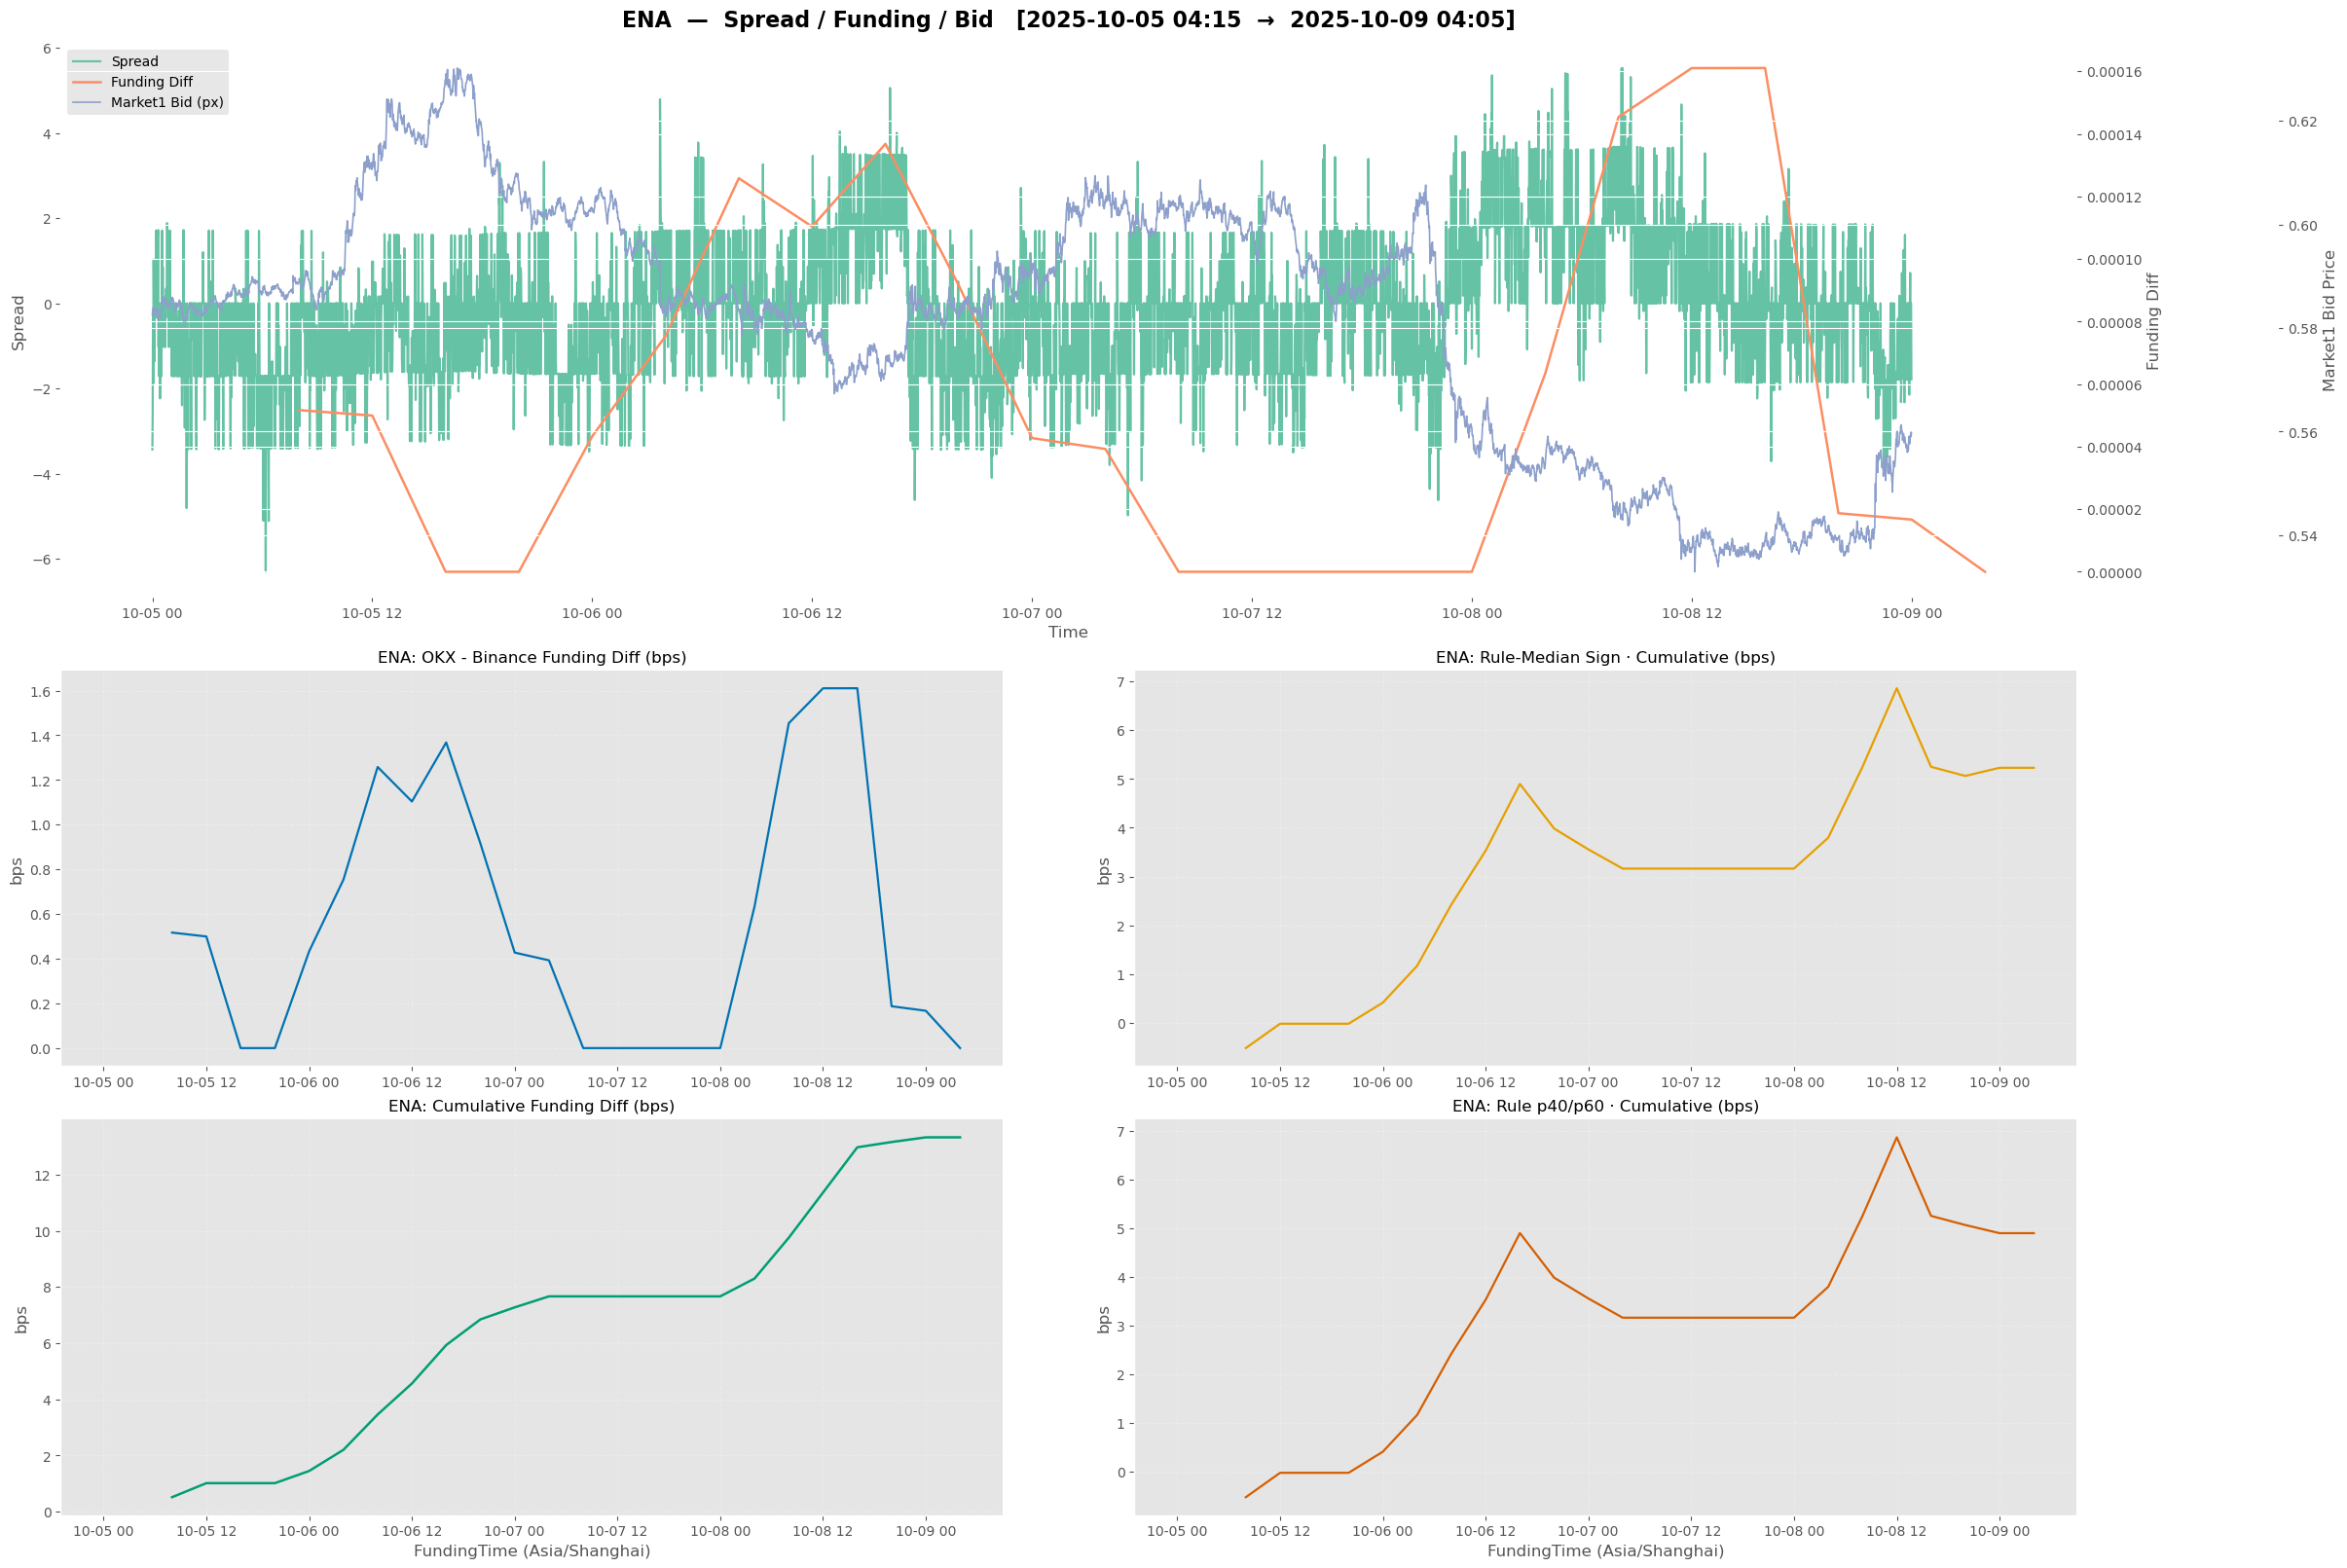

In [11]:
generate_cf_report(symbol, st, et, last_time)

In [21]:
# 读取价差数据
# settings
ccy = symbol
exchange1='binance' 
market1='swap'
exchange2='okx'     
market2='swap'
open_quantile = 0.95
close_quantile = 0.05
order_type = 'MT'
data_source = "nuts_mm"
market1_depth_path = f'/Users/rayxu/Downloads/nuts_am/data/{exchange1}/perp/books/{ccy}'
market2_depth_path = f'/Users/rayxu/Downloads/nuts_am/data/{exchange2}/perp/books/{ccy}'



market1_depth = pd.concat([pd.read_parquet(f'{market1_depth_path}/{ccy.lower()}usdt_{dd}_depth5.parquet')
                    for dd in pd.date_range(st, et).strftime('%Y-%m-%d')])        
market2_depth = pd.concat([pd.read_parquet(f'{market2_depth_path}/{ccy.lower()}usdt_{dd}_depth5.parquet')
                    for dd in pd.date_range(st, et).strftime('%Y-%m-%d')])

cf_depth = read_cf_depth(ccy, st, et, exchange1, market1, exchange2, market2, data_source=data_source)
cf_depth.set_index('beijing_time', inplace=True)


cf_depth['spread_bid'] = (cf_depth['market2_bid_price0'] / cf_depth['market1_bid_price0'] - 1) * 10000
cf_depth['spread_ask'] = (cf_depth['market2_ask_price0'] / cf_depth['market1_ask_price0'] - 1) * 10000

num_cols = cf_depth.select_dtypes(include='number').columns
roll10 = cf_depth[num_cols].rolling(window=10, min_periods=1).mean()

cf_depth_resampled = roll10.resample('60s').last().ffill()

spread_bid = cf_depth_resampled['spread_bid']
spread_ask = cf_depth_resampled['spread_ask']


KeyboardInterrupt: 

In [ ]:
symbol = ccy


okx_csv     = f'/Volumes/T7/Obentech/fundingRateData/okx/{symbol}-USDT-SWAP.csv'
binance_csv = f'/Volumes/T7/Obentech/fundingRateData/binance/{symbol}USDT.csv'

start_time = last_time - pd.Timedelta(days=4) +  pd.Timedelta(minutes=10)
df_okx     = process_funding_time_v3(okx_csv, 'okx')
df_binance = process_funding_time_v3(binance_csv, 'binance')

df_b = df_binance[(df_binance['Time'] >= start_time) & (df_binance['Time'] < last_time)].copy()
df_o = df_okx[(df_okx['Time'] >= start_time) & (df_okx['Time'] < last_time)].copy()


df_o = df_o.drop_duplicates(subset='FundingTime', keep='last')[:-1]
sum_okx = df_o['FundingRate'].sum()
df_b = df_b.drop_duplicates(subset='FundingTime', keep='last')[:-1]
sum_bnb = df_b['FundingRate'].sum()
earn    = sum_okx - sum_bnb
day_start = last_time - pd.Timedelta(days=1)

sum_okx1 = df_o[df_o['Time'] >= day_start]['FundingRate'].sum()
sum_bnb1 = df_b[df_b['Time'] >= day_start]['FundingRate'].sum()
earn_1day = sum_okx1 - sum_bnb1

funding_interval_bn = int((df_b.iloc[-1]['FundingTime'] - df_b.iloc[-2]['FundingTime']).total_seconds() / 3600)
funding_interval_okx = int((df_o.iloc[-1]['FundingTime'] - df_o.iloc[-2]['FundingTime']).total_seconds() / 3600)

df_o.rename(columns={'FundingRate': 'FundingRate_okx'}, inplace=True)
df_b.rename(columns={'FundingRate': 'FundingRate_binance'}, inplace=True)

if funding_interval_bn == funding_interval_okx:
    funding_diff = df_b[['FundingTime', 'FundingRate_binance']].set_index('FundingTime').join(df_o[['FundingTime', 'FundingRate_okx']].set_index('FundingTime'), how='left')
elif funding_interval_bn > funding_interval_okx:
    df_o_agg = df_o.set_index('FundingTime').resample(f'{funding_interval_bn}h', label='right', closed='right')['FundingRate_okx'].sum().to_frame()
    funding_diff = df_b[['FundingTime', 'FundingRate_binance']].set_index('FundingTime').join(df_o_agg, how='left')
else:
    df_b_agg = df_b.set_index('FundingTime').resample(f'{funding_interval_okx}h', label='right', closed='right')['FundingRate_binance'].sum().to_frame()
    funding_diff = df_o[['FundingTime', 'FundingRate_okx']].set_index('FundingTime').join(df_b_agg, how='left')


funding_diff['funding_diff']     = funding_diff['FundingRate_okx'] - funding_diff['FundingRate_binance']




# Type1

spread_resampled = spread_bid.copy().to_frame()
spread_resampled.columns = ['spread_bid_resampled']
spread_resampled['spread_ask_resampled'] = spread_ask


merged_df = funding_diff.merge(spread_resampled, left_index = True, right_index = True, how = 'left')
med_bid = spread_bid.quantile(0.5)
med_ask = spread_ask.quantile(0.5)
merged_df['sign'] = np.where(
    merged_df['spread_ask_resampled'] > med_ask,  1,
    np.where(merged_df['spread_bid_resampled'] < med_bid, -1, 1)
)
merged_df['funding_diff_adj'] = merged_df['funding_diff']*merged_df['sign']
merged_df['funding_diff_adj_cumsum'] = merged_df['funding_diff_adj'].cumsum()


# Type2
merged_df_type2 = merged_df.copy()
merged_df_type2['spread_ask_resampled'] = spread_ask

fd  = merged_df_type2['funding_diff']
spr_bid = merged_df_type2['spread_bid_resampled']
spr_ask = merged_df_type2['spread_ask_resampled']
p40 = spread_bid.quantile(0.4)
p60 = spread_ask.quantile(0.6)
merged_df_type2['p40'] = p40
merged_df_type2['p60'] = p60

# 规则：
# funding_diff > 0  → spr > p40 才 +1，否则 -1
# funding_diff < 0  → spr > p60 才 +1，否则 -1
# funding_diff == 0 → 设为 0（可按需改）
merged_df_type2['sign_rule'] = np.where(
    (fd > 0) & (spr_bid >= p40) | (fd < 0) & (spr_ask > p60), 
    1,
    np.where(fd == 0, 0, -1)
).astype('int8')

# 如需把贡献应用到 funding_diff
merged_df_type2['funding_diff_signed'] = fd * merged_df_type2['sign_rule']
merged_df_type2['funding_diff_signed_cumsum'] = merged_df_type2['funding_diff_signed'].cumsum()

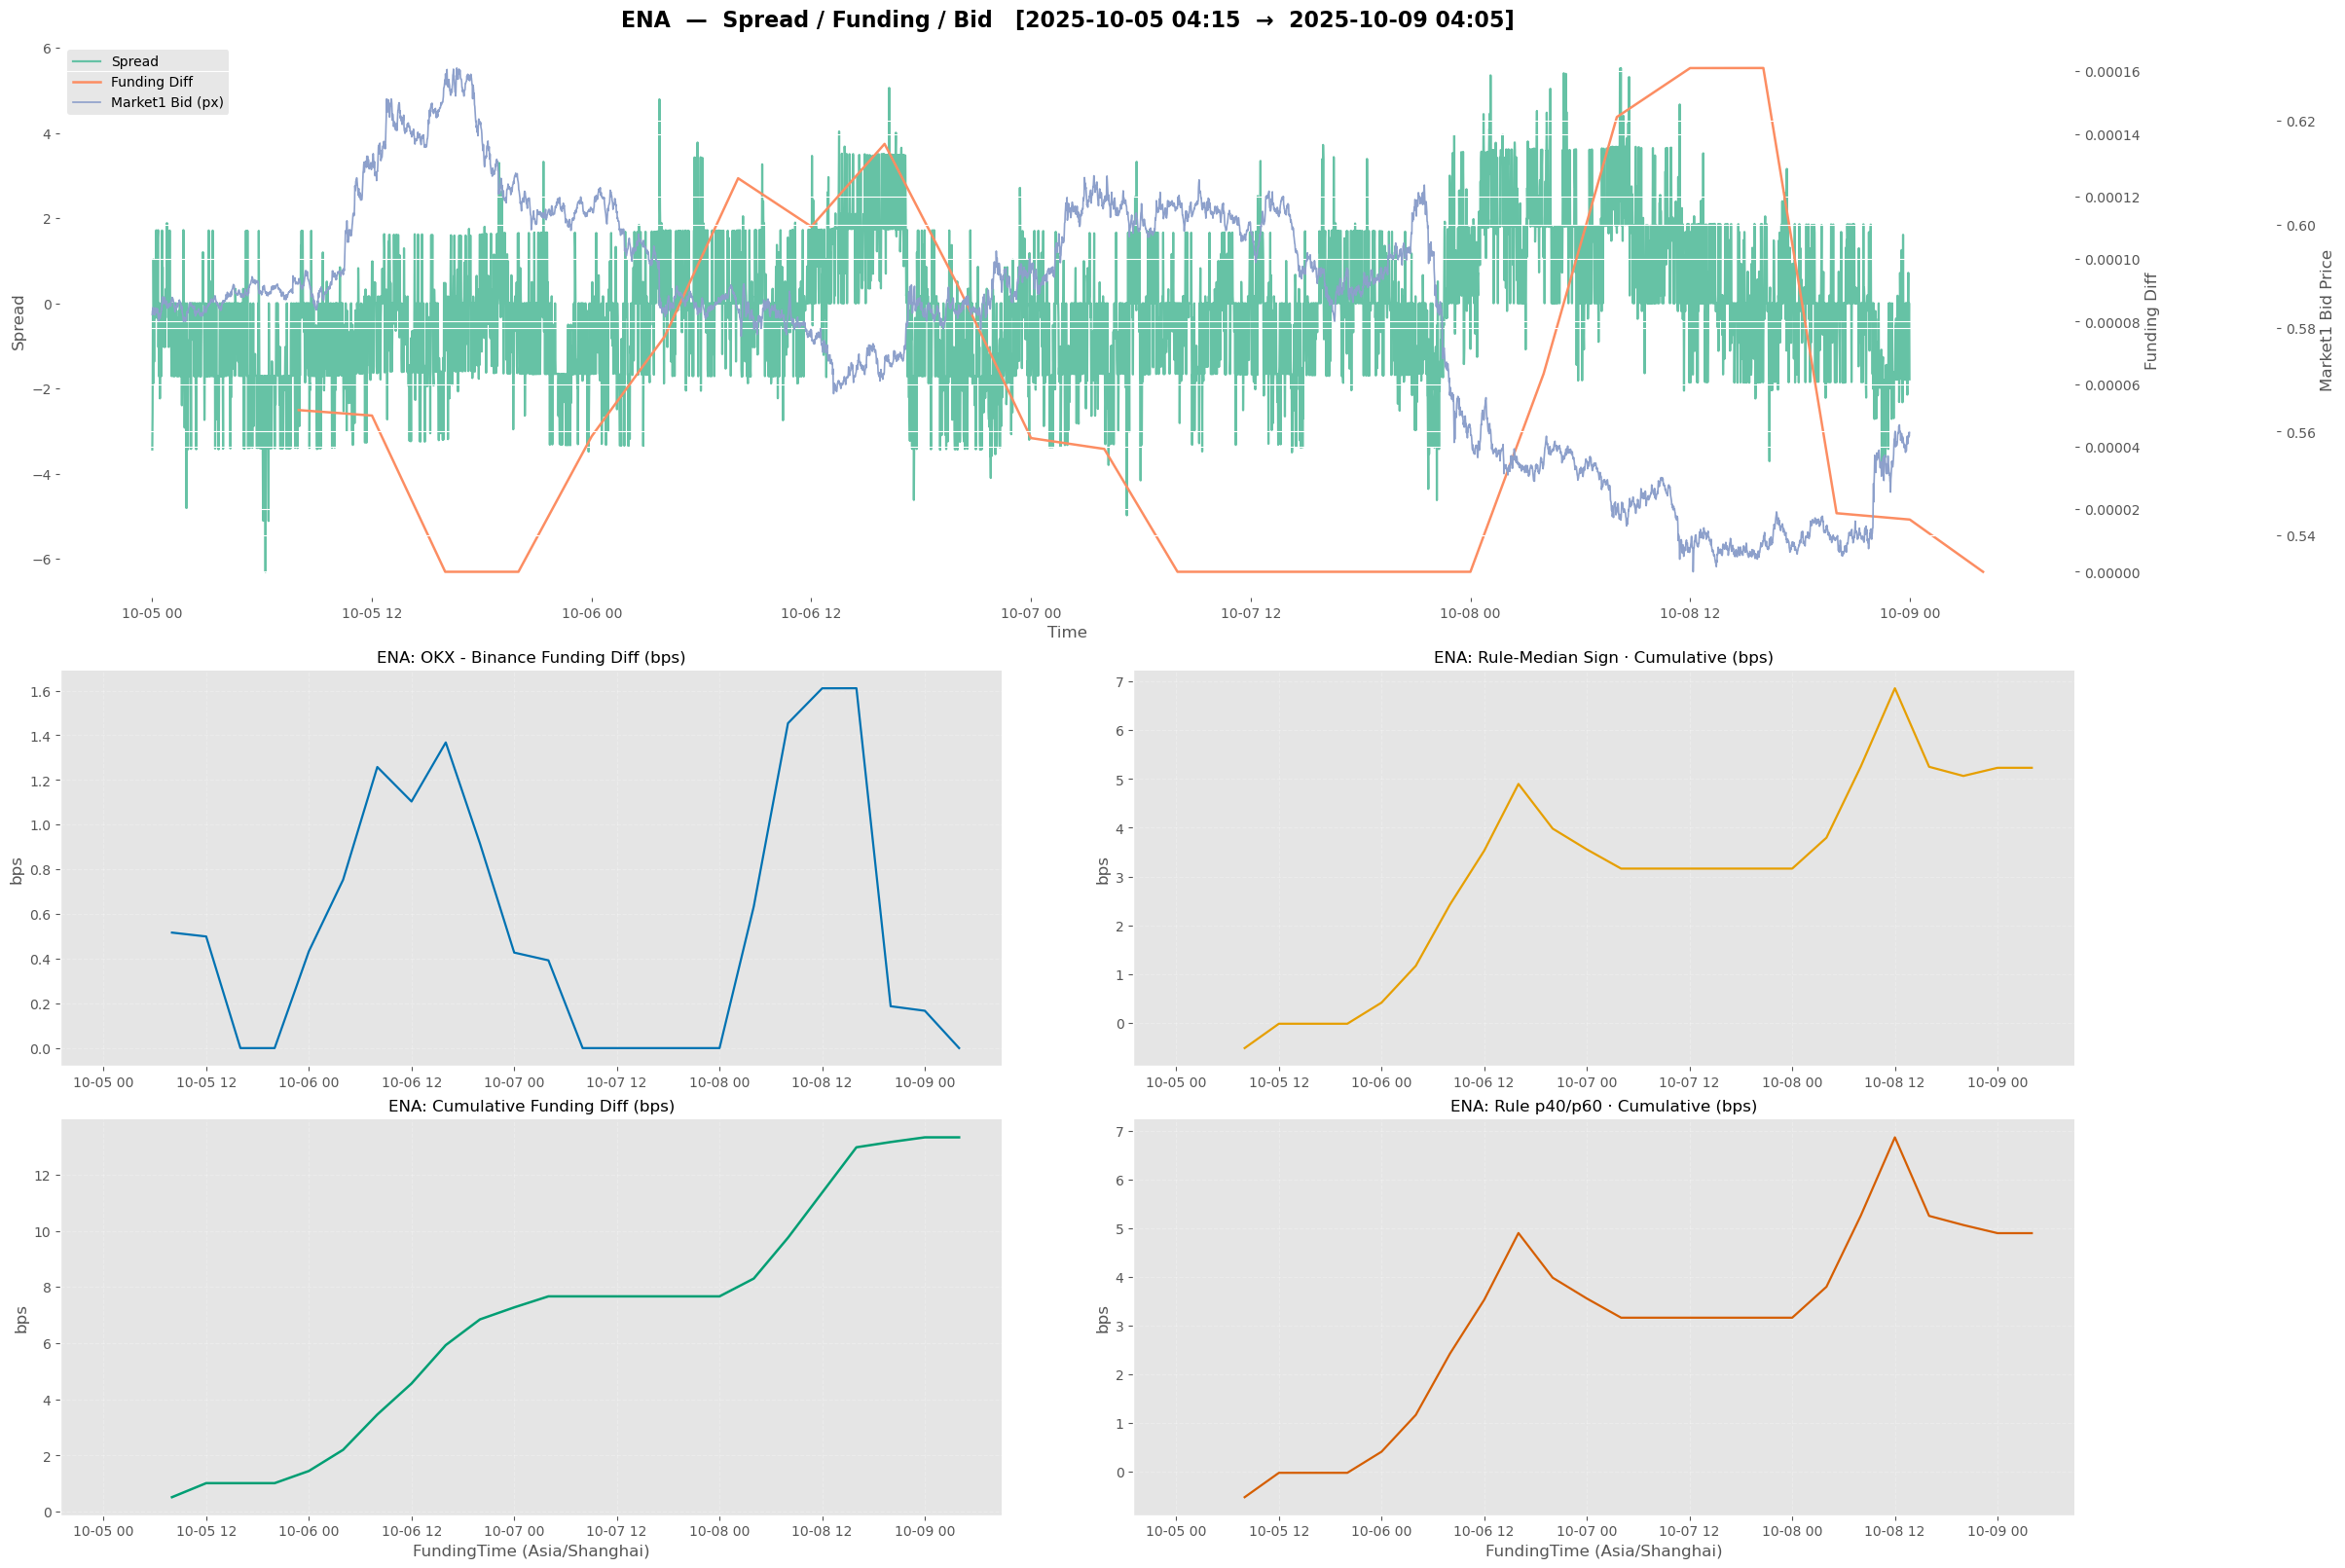

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# === 颜色配置 ===
COLOR_SPREAD  = "#66C2A5"
COLOR_FUNDING = "#FC8D62"
COLOR_BID     = "#8DA0CB"
C1 = "#0072B2"; C2 = "#009E73"; C3 = "#E69F00"; C4 = "#D55E00"

# === 数据准备 ===
symbol = ccy
idx = spread_bid.index
bid_px = cf_depth_resampled['market1_bid_price0'].reindex(idx)
funding_sorted = funding_diff.sort_index()

series_fd   = (funding_diff['funding_diff'] * 10000).dropna()
cumsum_vals = funding_diff['funding_diff'].cumsum()
if cumsum_vals.iloc[-1] < 0:
    cumsum_vals = -cumsum_vals
series_cum  = (cumsum_vals * 10000).dropna()
series_adj  = (merged_df['funding_diff_adj_cumsum'] * 10000).dropna()
series_sig  = (merged_df_type2['funding_diff_signed_cumsum'] * 10000).dropna()

# === 画布布局 ===
fig = plt.figure(constrained_layout=True, figsize=(24, 16))
gs  = GridSpec(nrows=3, ncols=2, figure=fig, height_ratios=[1.4, 1, 1])

# ------- 顶部大图 -------
ax_top = fig.add_subplot(gs[0, :])
ax_top.patch.set_visible(False)
ax_top.grid(False)

# 左轴：Spread
l1, = ax_top.plot(idx, spread_bid.values, label='Spread',
                  color=COLOR_SPREAD, linewidth=1.6, zorder=3)
ax_top.set_ylabel('Spread')
ax_top.set_xlabel('Time')

# 右轴：Funding
ax_top_r = ax_top.twinx()
ax_top_r.patch.set_visible(False)
l2, = ax_top_r.plot(funding_sorted.index, funding_sorted['funding_diff'].values,
                    linestyle='-', linewidth=1.8, color=COLOR_FUNDING,
                    label='Funding Diff', zorder=2)
ax_top_r.set_ylabel('Funding Diff')

# 第三个 y 轴：Bid
ax_top_r2 = ax_top.twinx()
ax_top_r2.spines['right'].set_position(('axes', 1.10))
ax_top_r2.patch.set_visible(False)
l3, = ax_top_r2.plot(idx, bid_px.values, label='Market1 Bid (px)',
                     color=COLOR_BID, linewidth=1.2, zorder=1)
ax_top_r2.set_ylabel('Market1 Bid Price')

# ----✅ 标题：Symbol + 时间范围----
title_str = (f"{symbol}  —  Spread / Funding / Bid"
             f"   [{start_time.strftime('%Y-%m-%d %H:%M')}  →  {last_time.strftime('%Y-%m-%d %H:%M')}]")
ax_top.set_title(title_str, fontsize=16, fontweight='bold', pad=12)

# 图例
lines = [l1, l2, l3]
labels = [ln.get_label() for ln in lines]
leg = ax_top.legend(lines, labels, loc='upper left')
leg.get_frame().set_alpha(0.9)
leg.get_frame().set_linewidth(0.0)

# ------- 底部 2×2 -------
ax11 = fig.add_subplot(gs[1, 0], sharex=ax_top)
ax12 = fig.add_subplot(gs[1, 1], sharex=ax_top)
ax21 = fig.add_subplot(gs[2, 0], sharex=ax_top)
ax22 = fig.add_subplot(gs[2, 1], sharex=ax_top)

for ax in (ax11, ax12, ax21, ax22):
    ax.grid(True, linestyle='--', alpha=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# (1) Funding Diff
ax11.plot(series_fd.index, series_fd.values, color=C1, linewidth=1.6)
ax11.set_title(f'{symbol}: OKX - Binance Funding Diff (bps)', fontsize=12)
ax11.set_ylabel('bps')

# (2) Rule-Median Sign 累计
ax12.plot(series_adj.index, series_adj.values, color=C3, linewidth=1.6)
ax12.set_title(f'{symbol}: Rule-Median Sign · Cumulative (bps)', fontsize=12)
ax12.set_ylabel('bps')

# (3) Cumulative Funding Diff
ax21.plot(series_cum.index, series_cum.values, color=C2, linewidth=1.8)
ax21.set_title(f'{symbol}: Cumulative Funding Diff (bps)', fontsize=12)
ax21.set_ylabel('bps')

# (4) Rule p40/p60 累计
ax22.plot(series_sig.index, series_sig.values, color=C4, linewidth=1.6)
ax22.set_title(f'{symbol}: Rule p40/p60 · Cumulative (bps)', fontsize=12)
ax22.set_ylabel('bps')

ax21.set_xlabel('FundingTime (Asia/Shanghai)')
ax22.set_xlabel('FundingTime (Asia/Shanghai)')

plt.show()


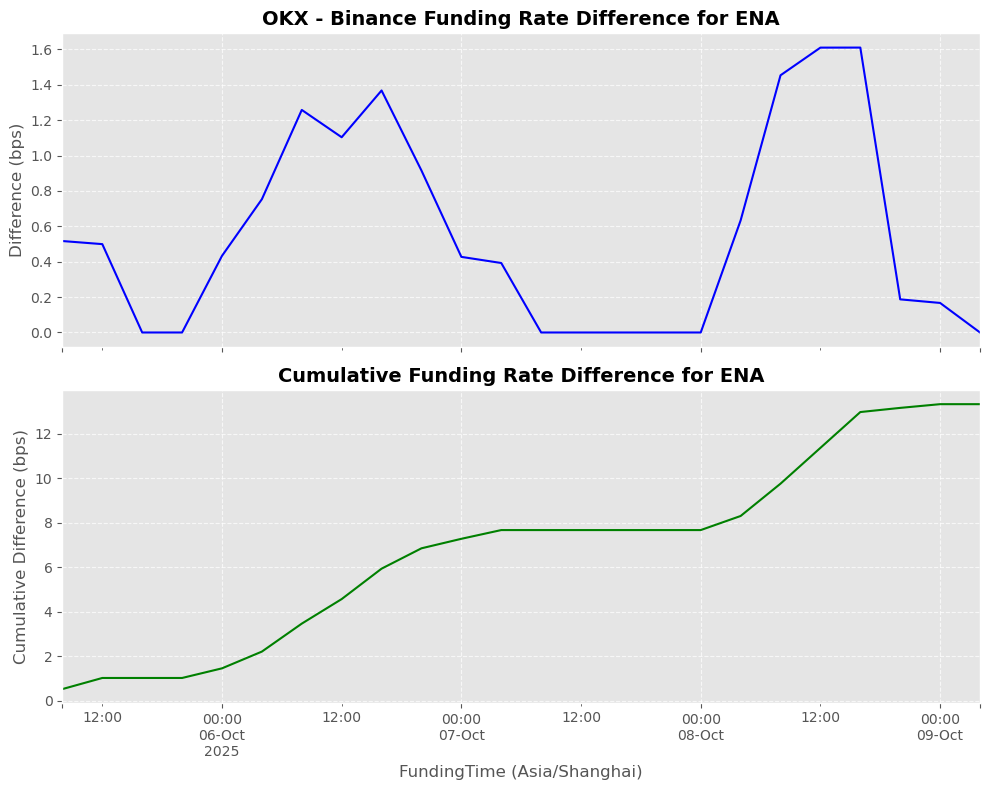

In [ ]:
# symbol = ccy


# okx_csv     = f'/Volumes/T7/Obentech/fundingRateData/okx/{symbol}-USDT-SWAP.csv'
# binance_csv = f'/Volumes/T7/Obentech/fundingRateData/binance/{symbol}USDT.csv'

# start_time = last_time - pd.Timedelta(days=4) +  pd.Timedelta(minutes=10)
# df_okx     = process_funding_time_v3(okx_csv, 'okx')
# df_binance = process_funding_time_v3(binance_csv, 'binance')

# df_b = df_binance[(df_binance['Time'] >= start_time) & (df_binance['Time'] < last_time)].copy()
# df_o = df_okx[(df_okx['Time'] >= start_time) & (df_okx['Time'] < last_time)].copy()


# df_o = df_o.drop_duplicates(subset='FundingTime', keep='last')[:-1]
# sum_okx = df_o['FundingRate'].sum()
# df_b = df_b.drop_duplicates(subset='FundingTime', keep='last')[:-1]
# sum_bnb = df_b['FundingRate'].sum()
# earn    = sum_okx - sum_bnb
# day_start = last_time - pd.Timedelta(days=1)

# sum_okx1 = df_o[df_o['Time'] >= day_start]['FundingRate'].sum()
# sum_bnb1 = df_b[df_b['Time'] >= day_start]['FundingRate'].sum()
# earn_1day = sum_okx1 - sum_bnb1

# funding_interval_bn = int((df_b.iloc[-1]['FundingTime'] - df_b.iloc[-2]['FundingTime']).total_seconds() / 3600)
# funding_interval_okx = int((df_o.iloc[-1]['FundingTime'] - df_o.iloc[-2]['FundingTime']).total_seconds() / 3600)

# df_o.rename(columns={'FundingRate': 'FundingRate_okx'}, inplace=True)
# df_b.rename(columns={'FundingRate': 'FundingRate_binance'}, inplace=True)

# if funding_interval_bn == funding_interval_okx:
#     funding_diff = df_b[['FundingTime', 'FundingRate_binance']].set_index('FundingTime').join(df_o[['FundingTime', 'FundingRate_okx']].set_index('FundingTime'), how='left')
# elif funding_interval_bn > funding_interval_okx:
#     df_o_agg = df_o.set_index('FundingTime').resample(f'{funding_interval_bn}h', label='right', closed='right')['FundingRate_okx'].sum().to_frame()
#     funding_diff = df_b[['FundingTime', 'FundingRate_binance']].set_index('FundingTime').join(df_o_agg, how='left')
# else:
#     df_b_agg = df_b.set_index('FundingTime').resample(f'{funding_interval_okx}h', label='right', closed='right')['FundingRate_binance'].sum().to_frame()
#     funding_diff = df_o[['FundingTime', 'FundingRate_okx']].set_index('FundingTime').join(df_b_agg, how='left')


# funding_diff['funding_diff']     = funding_diff['FundingRate_okx'] - funding_diff['FundingRate_binance']


# # 把图分成两个子图：一个显示资金费率差异，一个显示累计资金费率差异

# import matplotlib.pyplot as plt

# # Create a figure with two subplots
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# # Plot the funding rate difference in the first subplot
# (funding_diff['funding_diff']*10000).plot(ax=ax1, color='blue', linewidth=1.5)
# ax1.set_title(f'OKX - Binance Funding Rate Difference for {symbol}', fontsize=14, fontweight='bold')
# ax1.set_ylabel('Difference (bps)', fontsize=12)
# ax1.grid(True, linestyle='--', alpha=0.7)

# # Plot the cumulative funding rate difference in the second subplot
# # If the cumulative sum is negative, invert it
# cumsum_values = funding_diff['funding_diff'].cumsum()
# if cumsum_values.iloc[-1] < 0:
#     cumsum_values = -cumsum_values
# (cumsum_values*10000).plot(ax=ax2, color='green', linewidth=1.5)
# ax2.set_title(f'Cumulative Funding Rate Difference for {symbol}', fontsize=14, fontweight='bold')
# ax2.set_xlabel('FundingTime (Asia/Shanghai)', fontsize=12)
# ax2.set_ylabel('Cumulative Difference (bps)', fontsize=12)
# ax2.grid(True, linestyle='--', alpha=0.7)

# # Improve overall appearance
# plt.tight_layout()

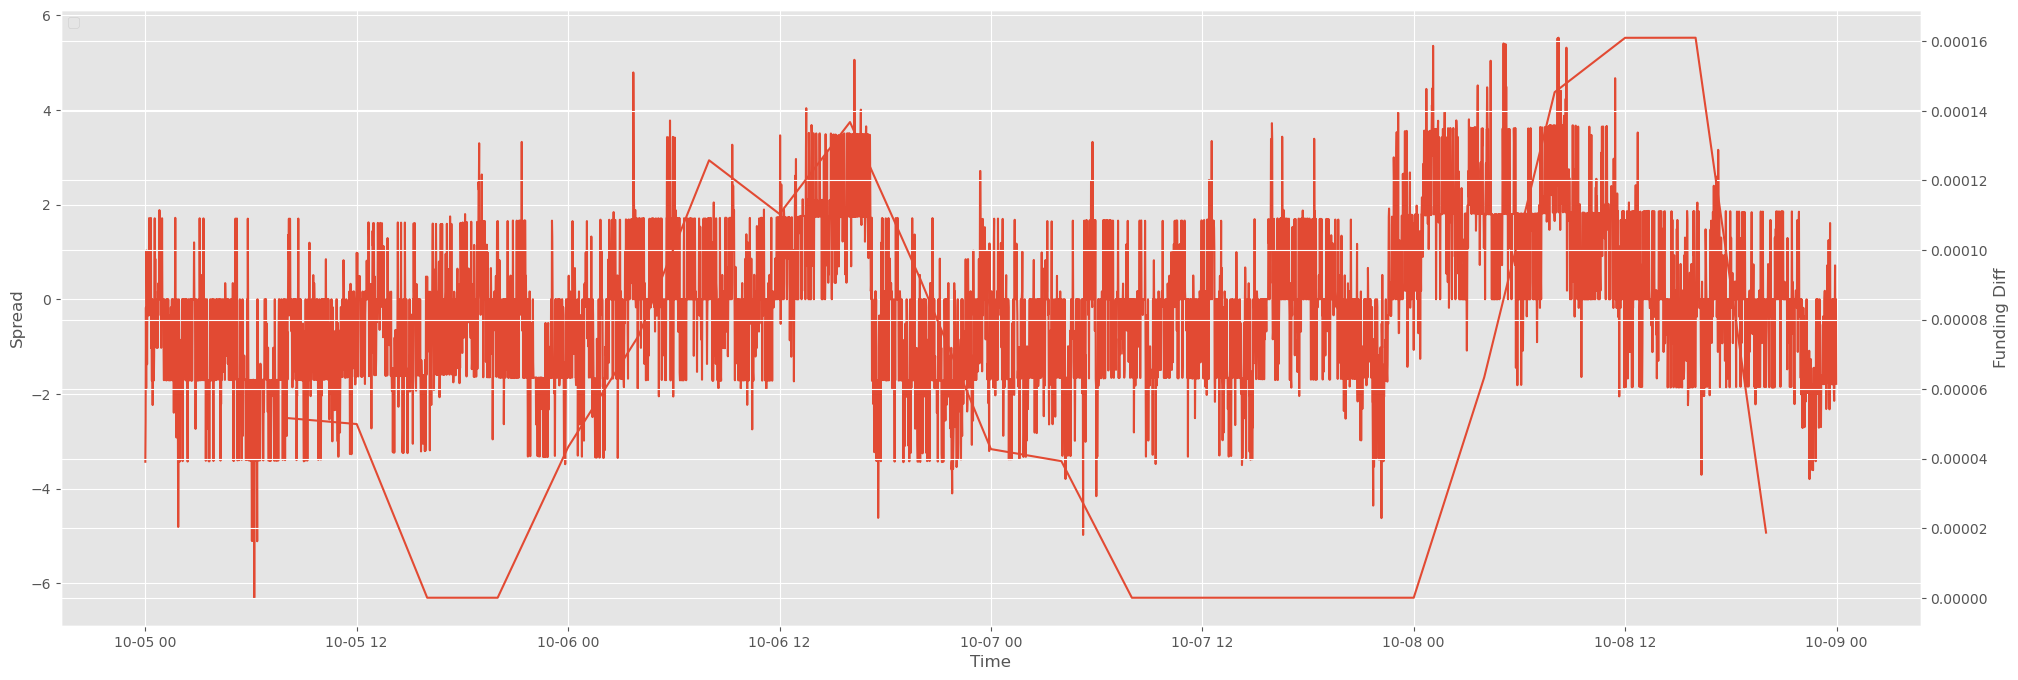

In [ ]:
# funding_diff = funding_diff[funding_diff.index.isin(spread_bid.index)]
# import matplotlib.pyplot as plt
# plt, ax1 = plt.subplots(figsize=(24, 8))
# # spread_bid_resampled and funding_diff using two axes

# spread_bid_resampled = spread_bid
# l1, = ax1.plot(spread_bid_resampled.index, spread_bid_resampled.values)
# ax1.set_ylabel('Spread')
# ax1.set_xlabel('Time')

# ax2 = ax1.twinx()
# l2, = ax2.plot(funding_diff.index, funding_diff['funding_diff'].values)
# ax2.set_ylabel('Funding Diff')

# lines = [l1, l2]
# labels = [l1.get_label(), l2.get_label()]
# ax1.legend(lines, labels, loc='upper left')

# plt.show()




<Axes: xlabel='FundingTime'>

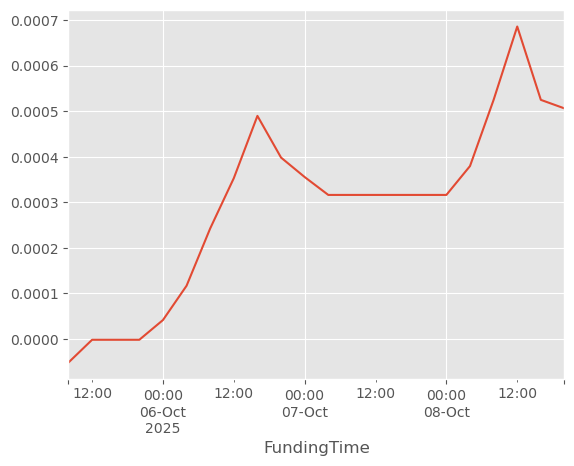

In [ ]:
# spread_resampled = spread_bid_resampled.copy().to_frame()
# spread_resampled.columns = ['spread_bid_resampled']
# spread_resampled['spread_ask_resampled'] = spread_ask


# merged_df = funding_diff.merge(spread_resampled, left_index = True, right_index = True, how = 'left')
# med_bid = spread_bid.quantile(0.5)
# med_ask = spread_ask.quantile(0.5)
# merged_df['sign'] = np.where(
#     merged_df['spread_ask_resampled'] > med_ask,  1,
#     np.where(merged_df['spread_bid_resampled'] < med_bid, -1, 1)
# )

# merged_df['funding_diff_adj'] = merged_df['funding_diff']*merged_df['sign']
# merged_df['funding_diff_adj_cumsum'] = merged_df['funding_diff_adj'].cumsum()
# merged_df['funding_diff_adj_cumsum'].plot()
# # merged_df['funding_diff_cumsum'] = (merged_df['funding_diff']).cumsum()
# # merged_df['funding_diff_cumsum'].plot()

In [ ]:
# merged_df_type2

,FundingRate_binance,FundingRate_okx,funding_diff,spread_bid_resampled,spread_ask_resampled,sign,funding_diff_adj,funding_diff_adj_cumsum,p40,p60,sign_rule,funding_diff_signed,funding_diff_signed_cumsum
FundingTime,,,,,,,,,,,,,
2025-10-05 08:00:00,-0.000002,0.000050,0.000052,-1.698370,-1.698081,-1,-0.000052,-0.000052,-0.17863,0.0,-1,-0.000052,-0.000052
2025-10-05 12:00:00,-0.000012,0.000038,0.000050,0.981836,0.981675,1,0.000050,-0.000002,-0.17863,0.0,1,0.000050,-0.000002
2025-10-05 16:00:00,0.000050,0.000050,0.000000,0.478011,0.477935,1,0.000000,-0.000002,-0.17863,0.0,0,0.000000,-0.000002
2025-10-05 20:00:00,0.000050,0.000050,0.000000,0.493665,0.493583,1,0.000000,-0.000002,-0.17863,0.0,0,0.000000,-0.000002
2025-10-06 00:00:00,0.000007,0.000050,0.000043,0.000000,0.497430,1,0.000043,0.000042,-0.17863,0.0,1,0.000043,0.000042
2025-10-06 04:00:00,-0.000025,0.000050,0.000075,0.000000,0.000000,1,0.000075,0.000117,-0.17863,0.0,1,0.000075,0.000117
2025-10-06 08:00:00,-0.000076,0.000050,0.000126,1.714090,1.713796,1,0.000126,0.000243,-0.17863,0.0,1,0.000126,0.000243
2025-10-06 12:00:00,-0.000060,0.000050,0.000110,1.725328,1.725030,1,0.000110,0.000353,-0.17863,0.0,1,0.000110,0.000353
2025-10-06 16:00:00,-0.000241,-0.000104,0.000137,3.490401,3.489792,1,0.000137,0.000490,-0.17863,0.0,1,0.000137,0.000490


<Axes: xlabel='FundingTime'>

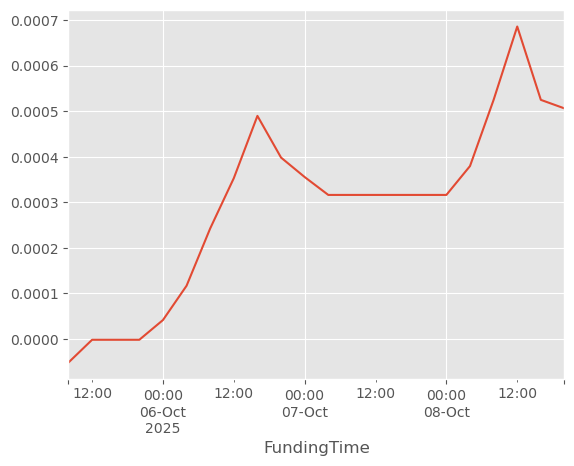

In [ ]:
# # Type2
# merged_df_type2 = merged_df.copy()
# merged_df_type2['spread_ask_resampled'] = spread_ask

# fd  = merged_df_type2['funding_diff']
# spr_bid = merged_df_type2['spread_bid_resampled']
# spr_ask = merged_df_type2['spread_ask_resampled']
# p40 = spread_bid.quantile(0.4)
# p60 = spread_ask.quantile(0.6)
# merged_df_type2['p40'] = p40
# merged_df_type2['p60'] = p60

# # 规则：
# # funding_diff > 0  → spr > p40 才 +1，否则 -1
# # funding_diff < 0  → spr > p60 才 +1，否则 -1
# # funding_diff == 0 → 设为 0（可按需改）
# merged_df_type2['sign_rule'] = np.where(
#     (fd > 0) & (spr_bid >= p40) | (fd < 0) & (spr_ask > p60), 
#     1,
#     np.where(fd == 0, 0, -1)
# ).astype('int8')

# # 如需把贡献应用到 funding_diff
# merged_df_type2['funding_diff_signed'] = fd * merged_df_type2['sign_rule']
# merged_df_type2['funding_diff_signed_cumsum'] = merged_df_type2['funding_diff_signed'].cumsum()
# merged_df_type2['funding_diff_signed_cumsum'].plot()

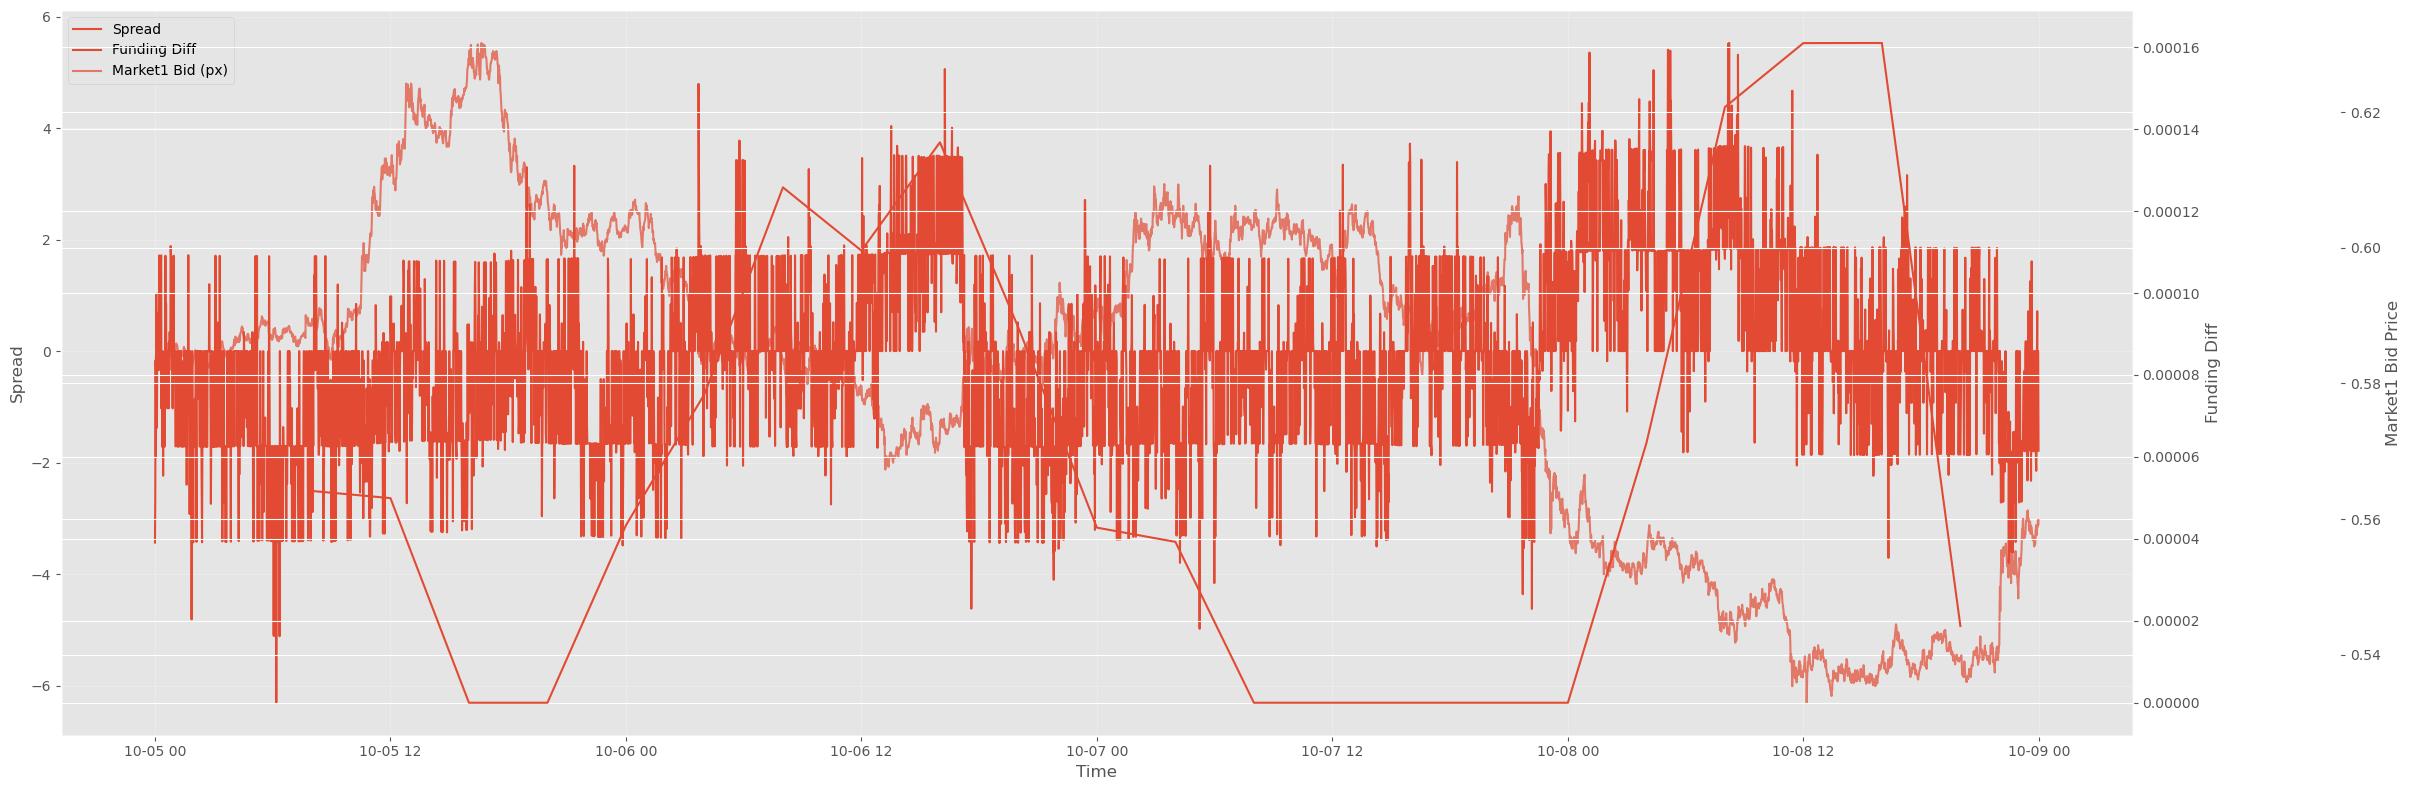

In [ ]:
# import matplotlib.pyplot as plt

# # 高频主索引（spread_bid 和 bid 同步）
# idx = spread_bid.index
# bid_px = cf_depth_resampled['market1_bid_price0'].reindex(idx)

# fig, ax1 = plt.subplots(figsize=(24, 8))

# # 左轴：Spread（高频）
# l1, = ax1.plot(idx, spread_bid.values, label='Spread')
# ax1.set_ylabel('Spread')
# ax1.set_xlabel('Time')
# ax1.grid(True, alpha=0.25)

# # 第三个 y 轴（右侧偏移）：Market1 Bid 价格
# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('axes', 1.10))
# ax3.set_frame_on(True); ax3.patch.set_visible(False)
# l3, = ax3.plot(idx, bid_px.values, label='Market1 Bid (px)', alpha=0.7)
# ax3.set_ylabel('Market1 Bid Price')

# # 右轴：Funding（稀疏 → 折线；保持原始稀疏时间，不做插值）
# ax2 = ax1.twinx()
# # 确保按时间排序（以防 index 未排序）
# funding_sorted = funding_diff.sort_index()
# l2, = ax2.plot(
#     funding_sorted.index,
#     funding_sorted['funding_diff'].values,
#     linestyle='-', linewidth=1.5, label='Funding Diff'
# )
# ax2.set_ylabel('Funding Diff')

# # 合并图例
# lines = [l1, l2, l3]
# labels = [ln.get_label() for ln in lines]
# ax1.legend(lines, labels, loc='upper left')

# plt.tight_layout()
# plt.show()


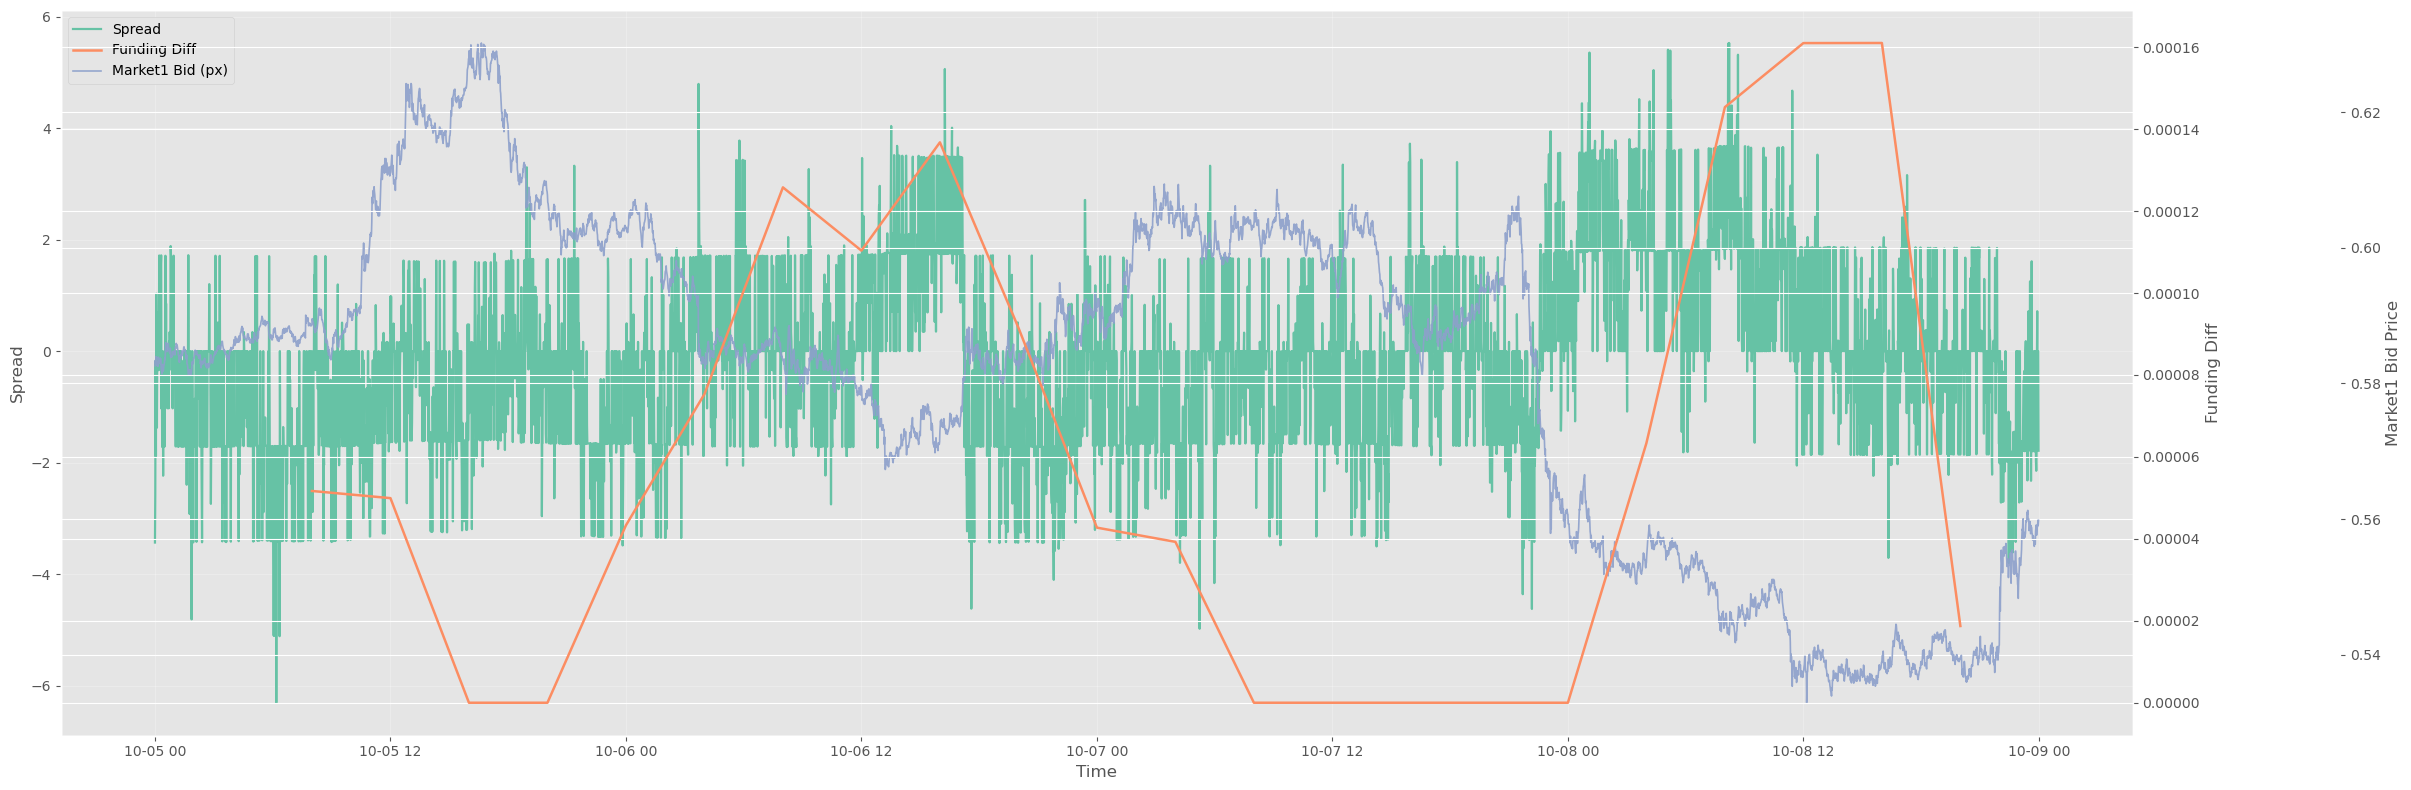

In [ ]:
# import matplotlib.pyplot as plt

# # 高频主索引（spread_bid 和 bid 同步）
# idx = spread_bid.index
# bid_px = cf_depth_resampled['market1_bid_price0'].reindex(idx)

# # 色盲友好配色
# COLOR_SPREAD  = "#66C2A5"  # 绿松
# COLOR_FUNDING = "#FC8D62"  # 橙珊瑚
# COLOR_BID     = "#8DA0CB"  # 淡紫蓝


# fig, ax1 = plt.subplots(figsize=(24, 8))

# # 左轴：Spread（高频）
# l1, = ax1.plot(idx, spread_bid.values, label='Spread',
#                color=COLOR_SPREAD, linewidth=1.6)
# ax1.set_ylabel('Spread')
# ax1.set_xlabel('Time')
# ax1.grid(False, alpha=0.25)
# # ax2.patch.set_visible(False)
# # 第三个 y 轴（右侧偏移）：Market1 Bid 价格
# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('axes', 1.10))
# ax3.set_frame_on(True); ax3.patch.set_visible(False)
# l3, = ax3.plot(idx, bid_px.values, label='Market1 Bid (px)',
#                color=COLOR_BID, linewidth=1.2, alpha=0.9)
# ax3.set_ylabel('Market1 Bid Price')

# # 右轴：Funding（稀疏 → 折线；保持原始稀疏时间，不插值）
# ax2 = ax1.twinx()
# funding_sorted = funding_diff.sort_index()
# l2, = ax2.plot(funding_sorted.index, funding_sorted['funding_diff'].values,
#                linestyle='-', linewidth=1.8, color=COLOR_FUNDING,
#                label='Funding Diff')
# ax2.set_ylabel('Funding Diff')
# # ax2.patch.set_visible(False)
# # 合并图例
# lines = [l1, l2, l3]
# labels = [ln.get_label() for ln in lines]
# ax1.legend(lines, labels, loc='upper left')

# plt.tight_layout()
# plt.show()


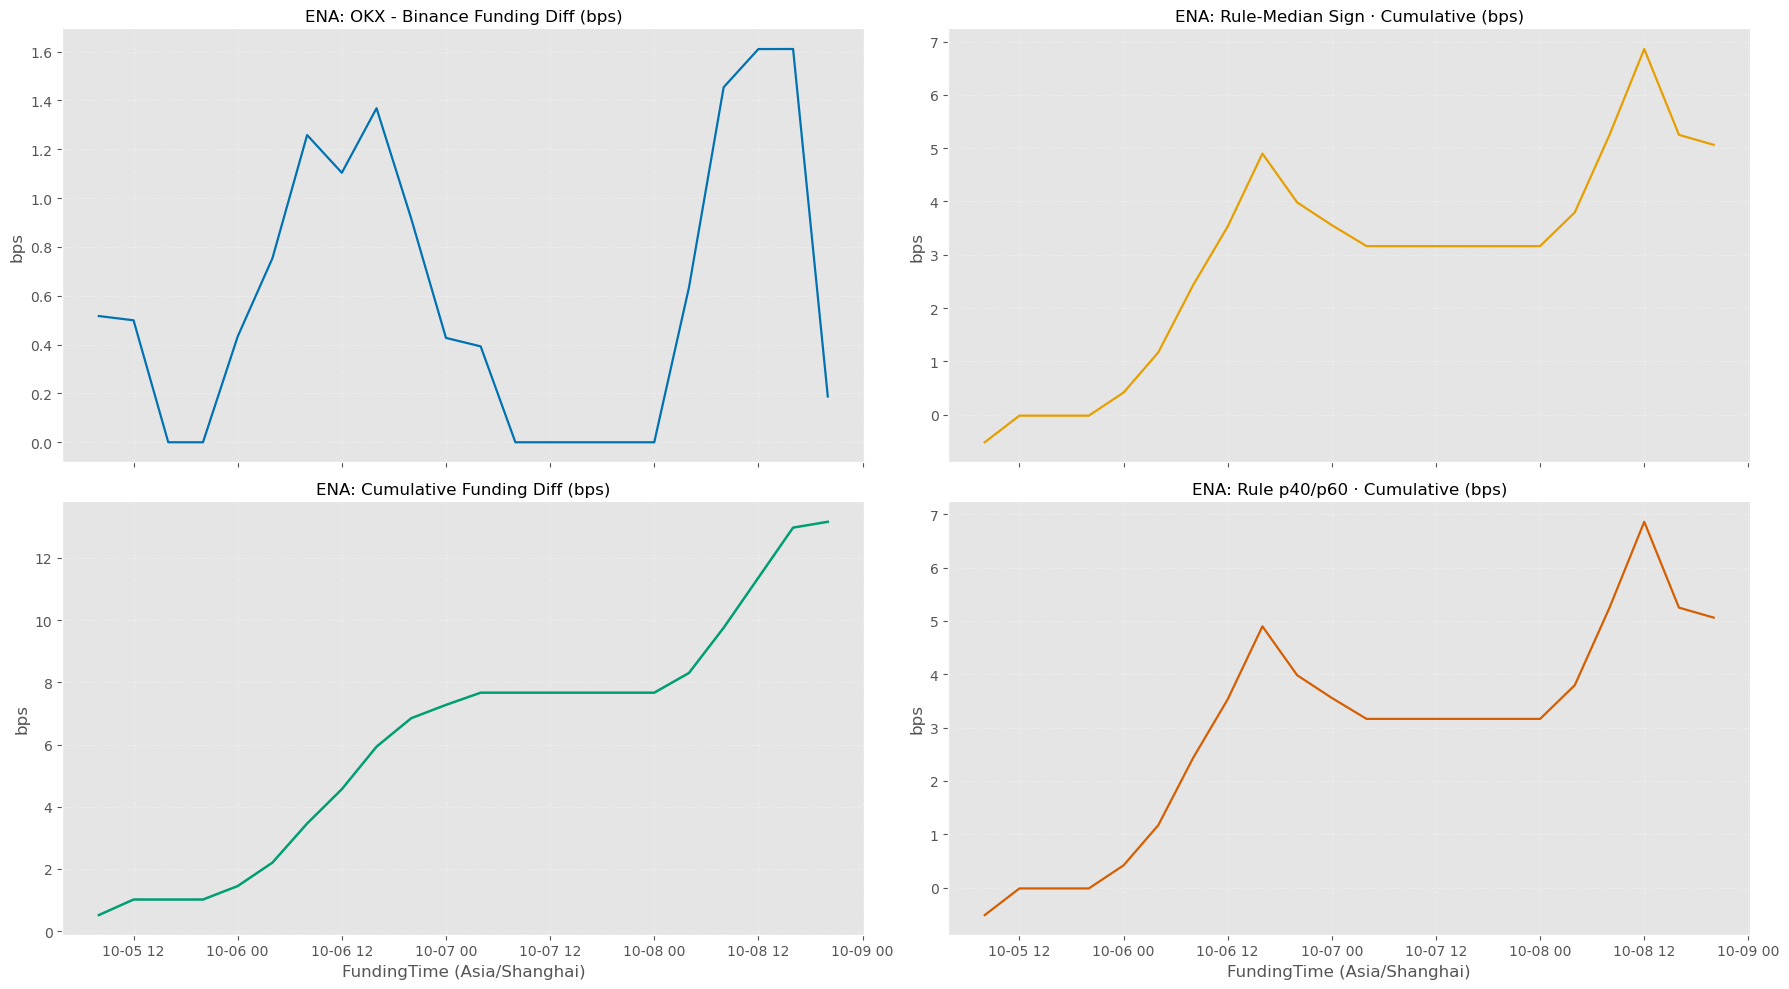

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # --- 你前面的数据准备保持不变 ---

# # 配色（Okabe–Ito）
# C1 = "#0072B2"  # 蓝: funding_diff
# C2 = "#009E73"  # 绿: 累计
# C3 = "#E69F00"  # 橙: 规则1累计
# C4 = "#D55E00"  # 橙棕: 规则2累计

# # --- 子图 2×2 ---
# fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
# (ax11, ax12), (ax21, ax22) = axes

# for ax in (ax11, ax12, ax21, ax22):
#     ax.grid(True, linestyle='--', alpha=0.25)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

# # 1) funding_diff（bps）
# series_fd = (funding_diff['funding_diff'] * 10000).dropna()
# ax11.plot(series_fd.index, series_fd.values, color=C1, linewidth=1.6)
# ax11.set_title(f'{symbol}: OKX - Binance Funding Diff (bps)', fontsize=12)
# ax11.set_ylabel('bps')

# # 2) Rule-Median Sign 累计
# series_adj = (merged_df['funding_diff_adj_cumsum'] * 10000).dropna()
# ax12.plot(series_adj.index, series_adj.values, color=C3, linewidth=1.6)
# ax12.set_title(f'{symbol}: Rule-Median Sign · Cumulative (bps)', fontsize=12)
# ax12.set_ylabel('bps')

# # 3) Cumulative Funding Diff
# cumsum_values = funding_diff['funding_diff'].cumsum()
# if cumsum_values.iloc[-1] < 0:
#     cumsum_values = -cumsum_values
# series_cum = (cumsum_values * 10000).dropna()
# ax21.plot(series_cum.index, series_cum.values, color=C2, linewidth=1.8)
# ax21.set_title(f'{symbol}: Cumulative Funding Diff (bps)', fontsize=12)
# ax21.set_ylabel('bps')

# # 4) Type2：p40/p60 规则累计
# series_signed = (merged_df_type2['funding_diff_signed_cumsum'] * 10000).dropna()
# ax22.plot(series_signed.index, series_signed.values, color=C4, linewidth=1.6)
# ax22.set_title(f'{symbol}: Rule p40/p60 · Cumulative (bps)', fontsize=12)
# ax22.set_ylabel('bps')

# for ax in (ax21, ax22):
#     ax.set_xlabel('FundingTime (Asia/Shanghai)')

# plt.tight_layout()
# plt.show()


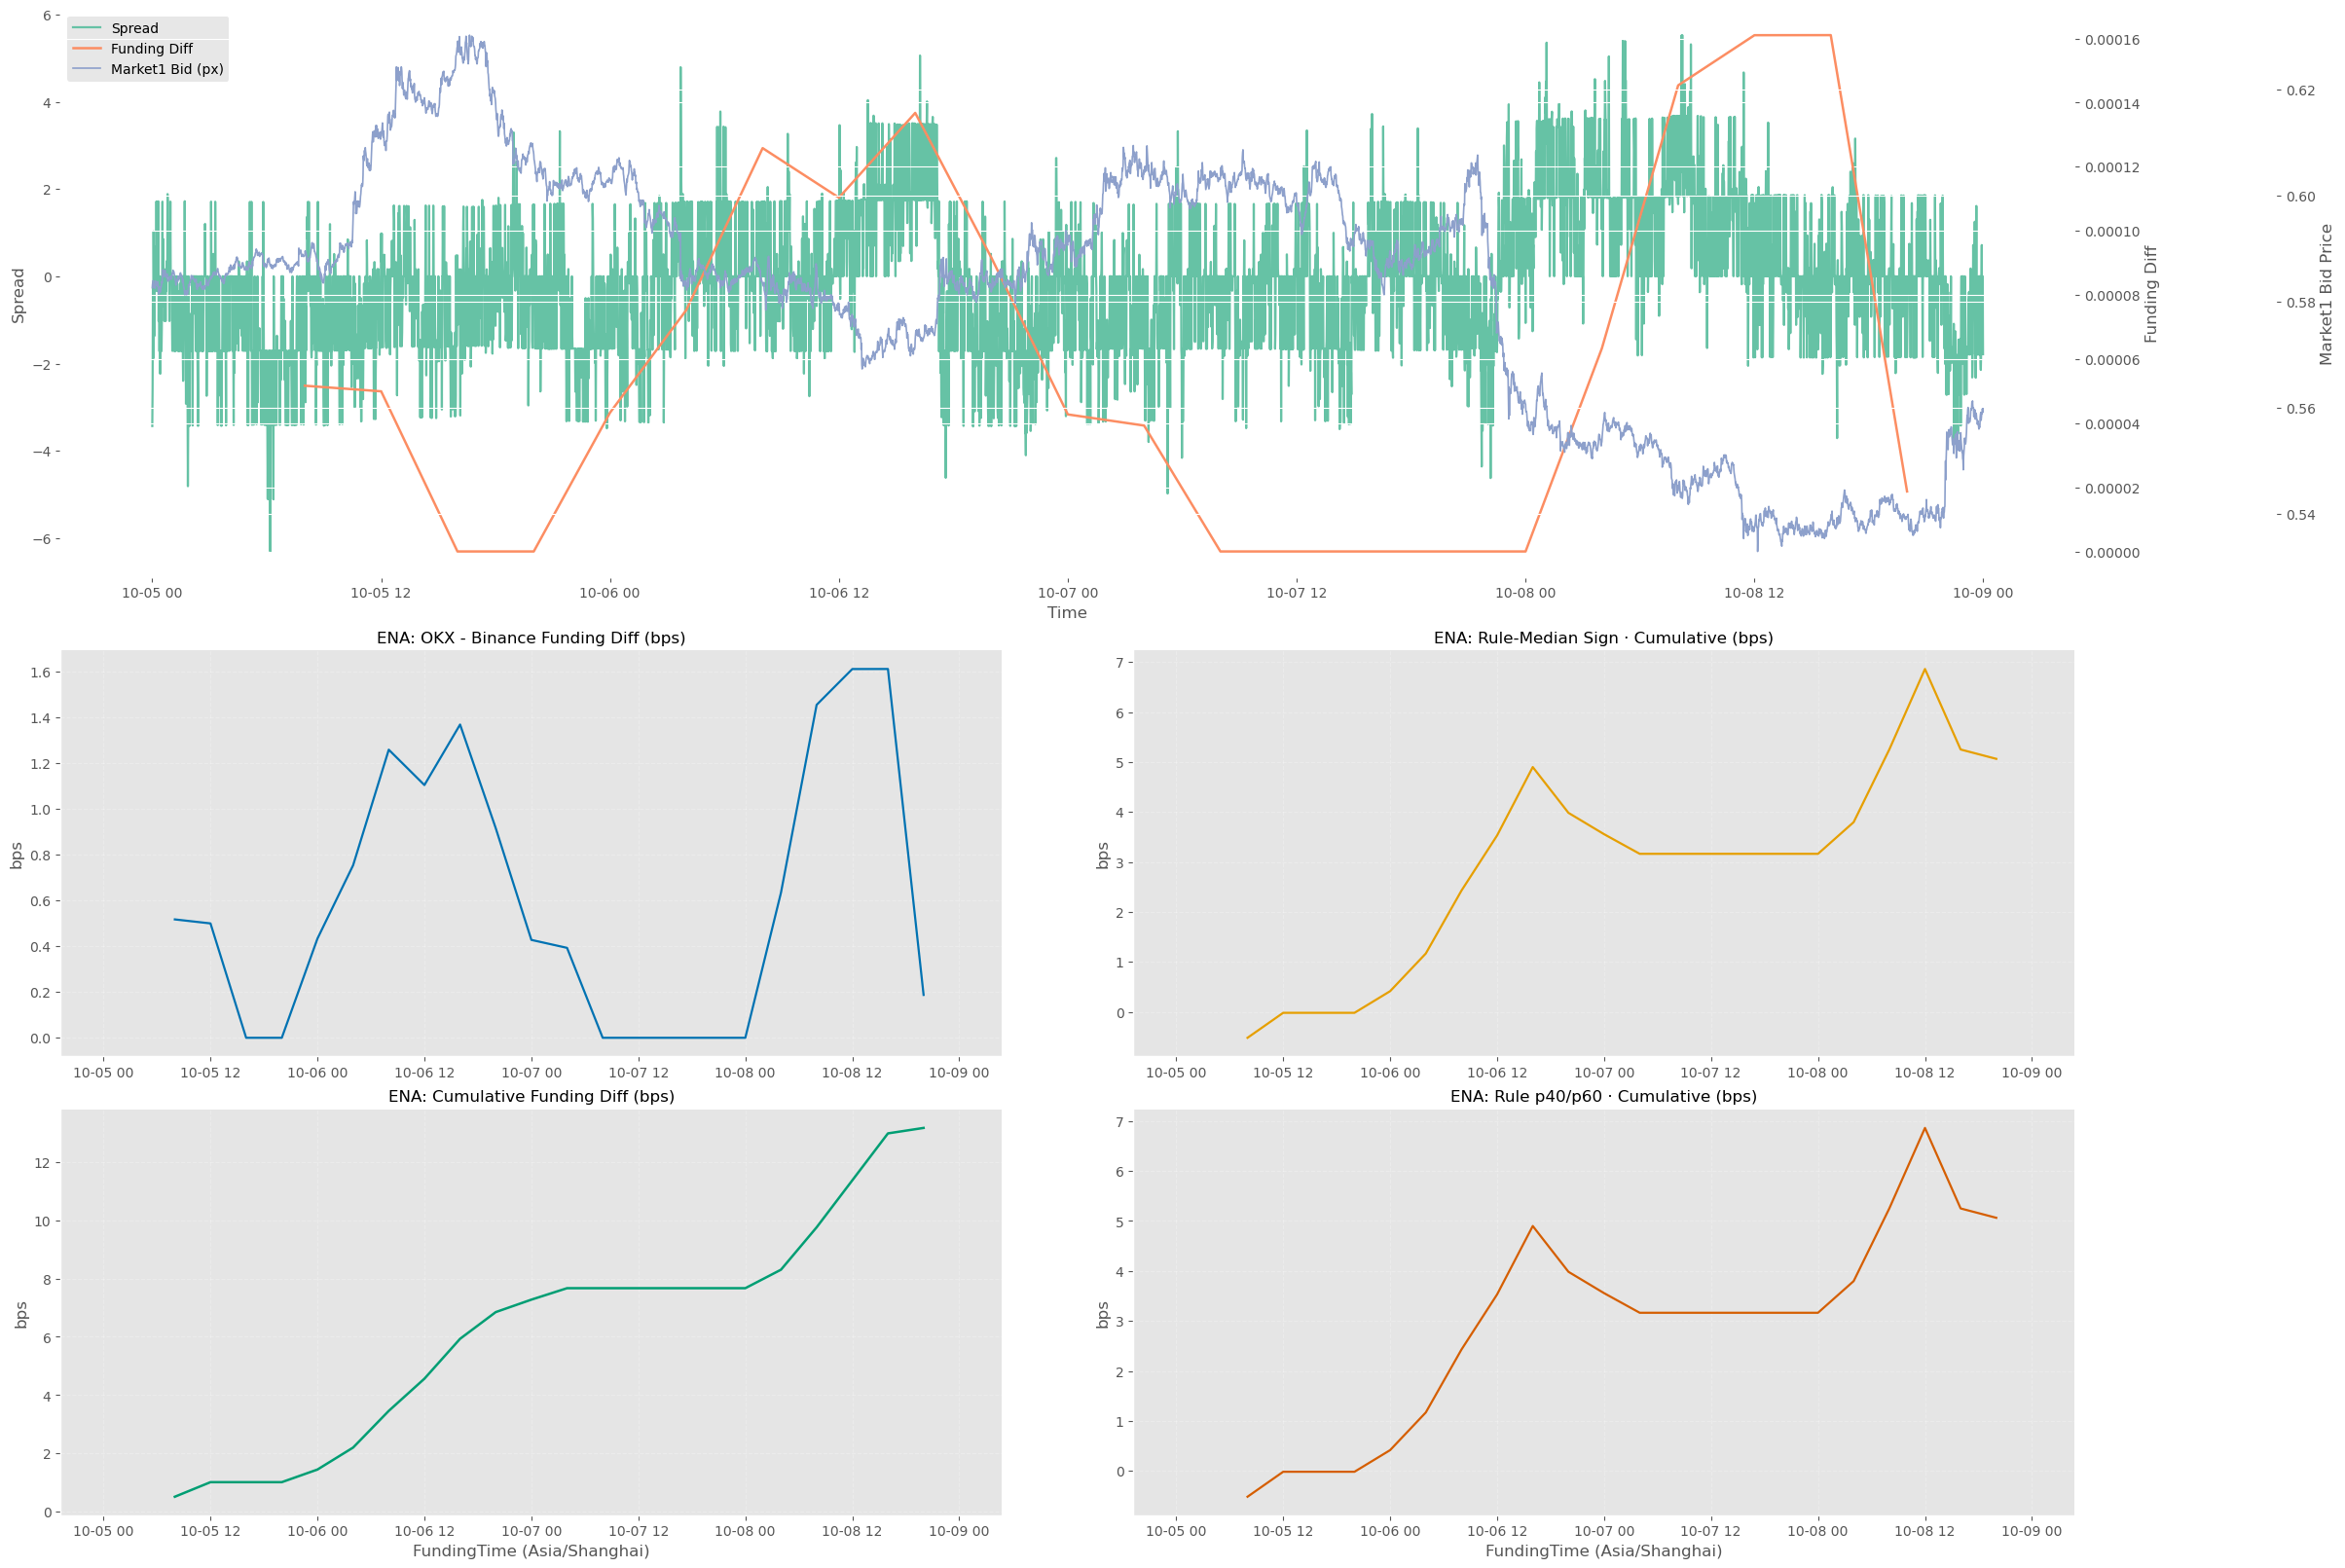

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

# # === 颜色配置 ===
# COLOR_SPREAD  = "#66C2A5"  # 绿松（上方大图：Spread）
# COLOR_FUNDING = "#FC8D62"  # 橙珊瑚（上方大图：Funding Diff）
# COLOR_BID     = "#8DA0CB"  # 淡紫蓝（上方大图：Bid）

# # 下方 2×2 使用 Okabe–Ito
# C1 = "#0072B2"  # 蓝: funding_diff
# C2 = "#009E73"  # 绿: 累计
# C3 = "#E69F00"  # 橙: Rule-Median Sign 累计
# C4 = "#D55E00"  # 橙棕: p40/p60 规则累计

# # === 数据准备（沿用你已有变量）===
# symbol = ccy
# idx = spread_bid.index
# bid_px = cf_depth_resampled['market1_bid_price0'].reindex(idx)
# funding_sorted = funding_diff.sort_index()

# # 下方四图用到的序列
# series_fd   = (funding_diff['funding_diff'] * 10000).dropna()
# cumsum_vals = funding_diff['funding_diff'].cumsum()
# if cumsum_vals.iloc[-1] < 0:
#     cumsum_vals = -cumsum_vals
# series_cum  = (cumsum_vals * 10000).dropna()
# series_adj  = (merged_df['funding_diff_adj_cumsum'] * 10000).dropna()
# series_sig  = (merged_df_type2['funding_diff_signed_cumsum'] * 10000).dropna()

# # === 画布与布局 ===
# fig = plt.figure(constrained_layout=True, figsize=(24, 16))
# gs  = GridSpec(nrows=3, ncols=2, figure=fig, height_ratios=[1.4, 1, 1])

# # ------- 顶部大图：三轴合一 -------
# ax_top = fig.add_subplot(gs[0, :])           # 跨两列
# ax_top.patch.set_visible(False)
# ax_top.grid(False)

# # 左轴：Spread
# l1, = ax_top.plot(idx, spread_bid.values, label='Spread',
#                   color=COLOR_SPREAD, linewidth=1.6, zorder=3)
# ax_top.set_ylabel('Spread')
# ax_top.set_xlabel('Time')

# # 右轴：Funding（稀疏→折线）
# ax_top_r = ax_top.twinx()
# ax_top_r.patch.set_visible(False)
# l2, = ax_top_r.plot(funding_sorted.index, funding_sorted['funding_diff'].values,
#                     linestyle='-', linewidth=1.8, color=COLOR_FUNDING,
#                     label='Funding Diff', zorder=2)
# ax_top_r.set_ylabel('Funding Diff')

# # 第三个 y 轴：Bid（右移）
# ax_top_r2 = ax_top.twinx()
# ax_top_r2.spines['right'].set_position(('axes', 1.10))
# ax_top_r2.patch.set_visible(False)
# l3, = ax_top_r2.plot(idx, bid_px.values, label='Market1 Bid (px)',
#                      color=COLOR_BID, linewidth=1.2, zorder=1)
# ax_top_r2.set_ylabel('Market1 Bid Price')

# # 合并图例
# lines = [l1, l2, l3]
# labels = [ln.get_label() for ln in lines]
# leg = ax_top.legend(lines, labels, loc='upper left')
# leg.get_frame().set_alpha(0.9)
# leg.get_frame().set_linewidth(0.0)

# # ------- 底部 2×2 -------
# ax11 = fig.add_subplot(gs[1, 0], sharex=ax_top)  # 左上：Funding Diff (bps)
# ax12 = fig.add_subplot(gs[1, 1], sharex=ax_top)  # 右上：Rule-Median Sign Cumulative
# ax21 = fig.add_subplot(gs[2, 0], sharex=ax_top)  # 左下：Cumulative Funding Diff
# ax22 = fig.add_subplot(gs[2, 1], sharex=ax_top)  # 右下：Rule p40/p60 Cumulative

# for ax in (ax11, ax12, ax21, ax22):
#     ax.grid(True, linestyle='--', alpha=0.25)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

# # 1) Funding Diff（bps）
# ax11.plot(series_fd.index, series_fd.values, color=C1, linewidth=1.6)
# ax11.set_title(f'{symbol}: OKX - Binance Funding Diff (bps)', fontsize=12)
# ax11.set_ylabel('bps')

# # 2) Rule-Median Sign 累计（已按你要求放在右上）
# ax12.plot(series_adj.index, series_adj.values, color=C3, linewidth=1.6)
# ax12.set_title(f'{symbol}: Rule-Median Sign · Cumulative (bps)', fontsize=12)
# ax12.set_ylabel('bps')

# # 3) Cumulative Funding Diff（左下）
# ax21.plot(series_cum.index, series_cum.values, color=C2, linewidth=1.8)
# ax21.set_title(f'{symbol}: Cumulative Funding Diff (bps)', fontsize=12)
# ax21.set_ylabel('bps')

# # 4) Rule p40/p60 累计（右下）
# ax22.plot(series_sig.index, series_sig.values, color=C4, linewidth=1.6)
# ax22.set_title(f'{symbol}: Rule p40/p60 · Cumulative (bps)', fontsize=12)
# ax22.set_ylabel('bps')

# # 统一底部两幅的 x 标签
# ax21.set_xlabel('FundingTime (Asia/Shanghai)')
# ax22.set_xlabel('FundingTime (Asia/Shanghai)')

# plt.show()


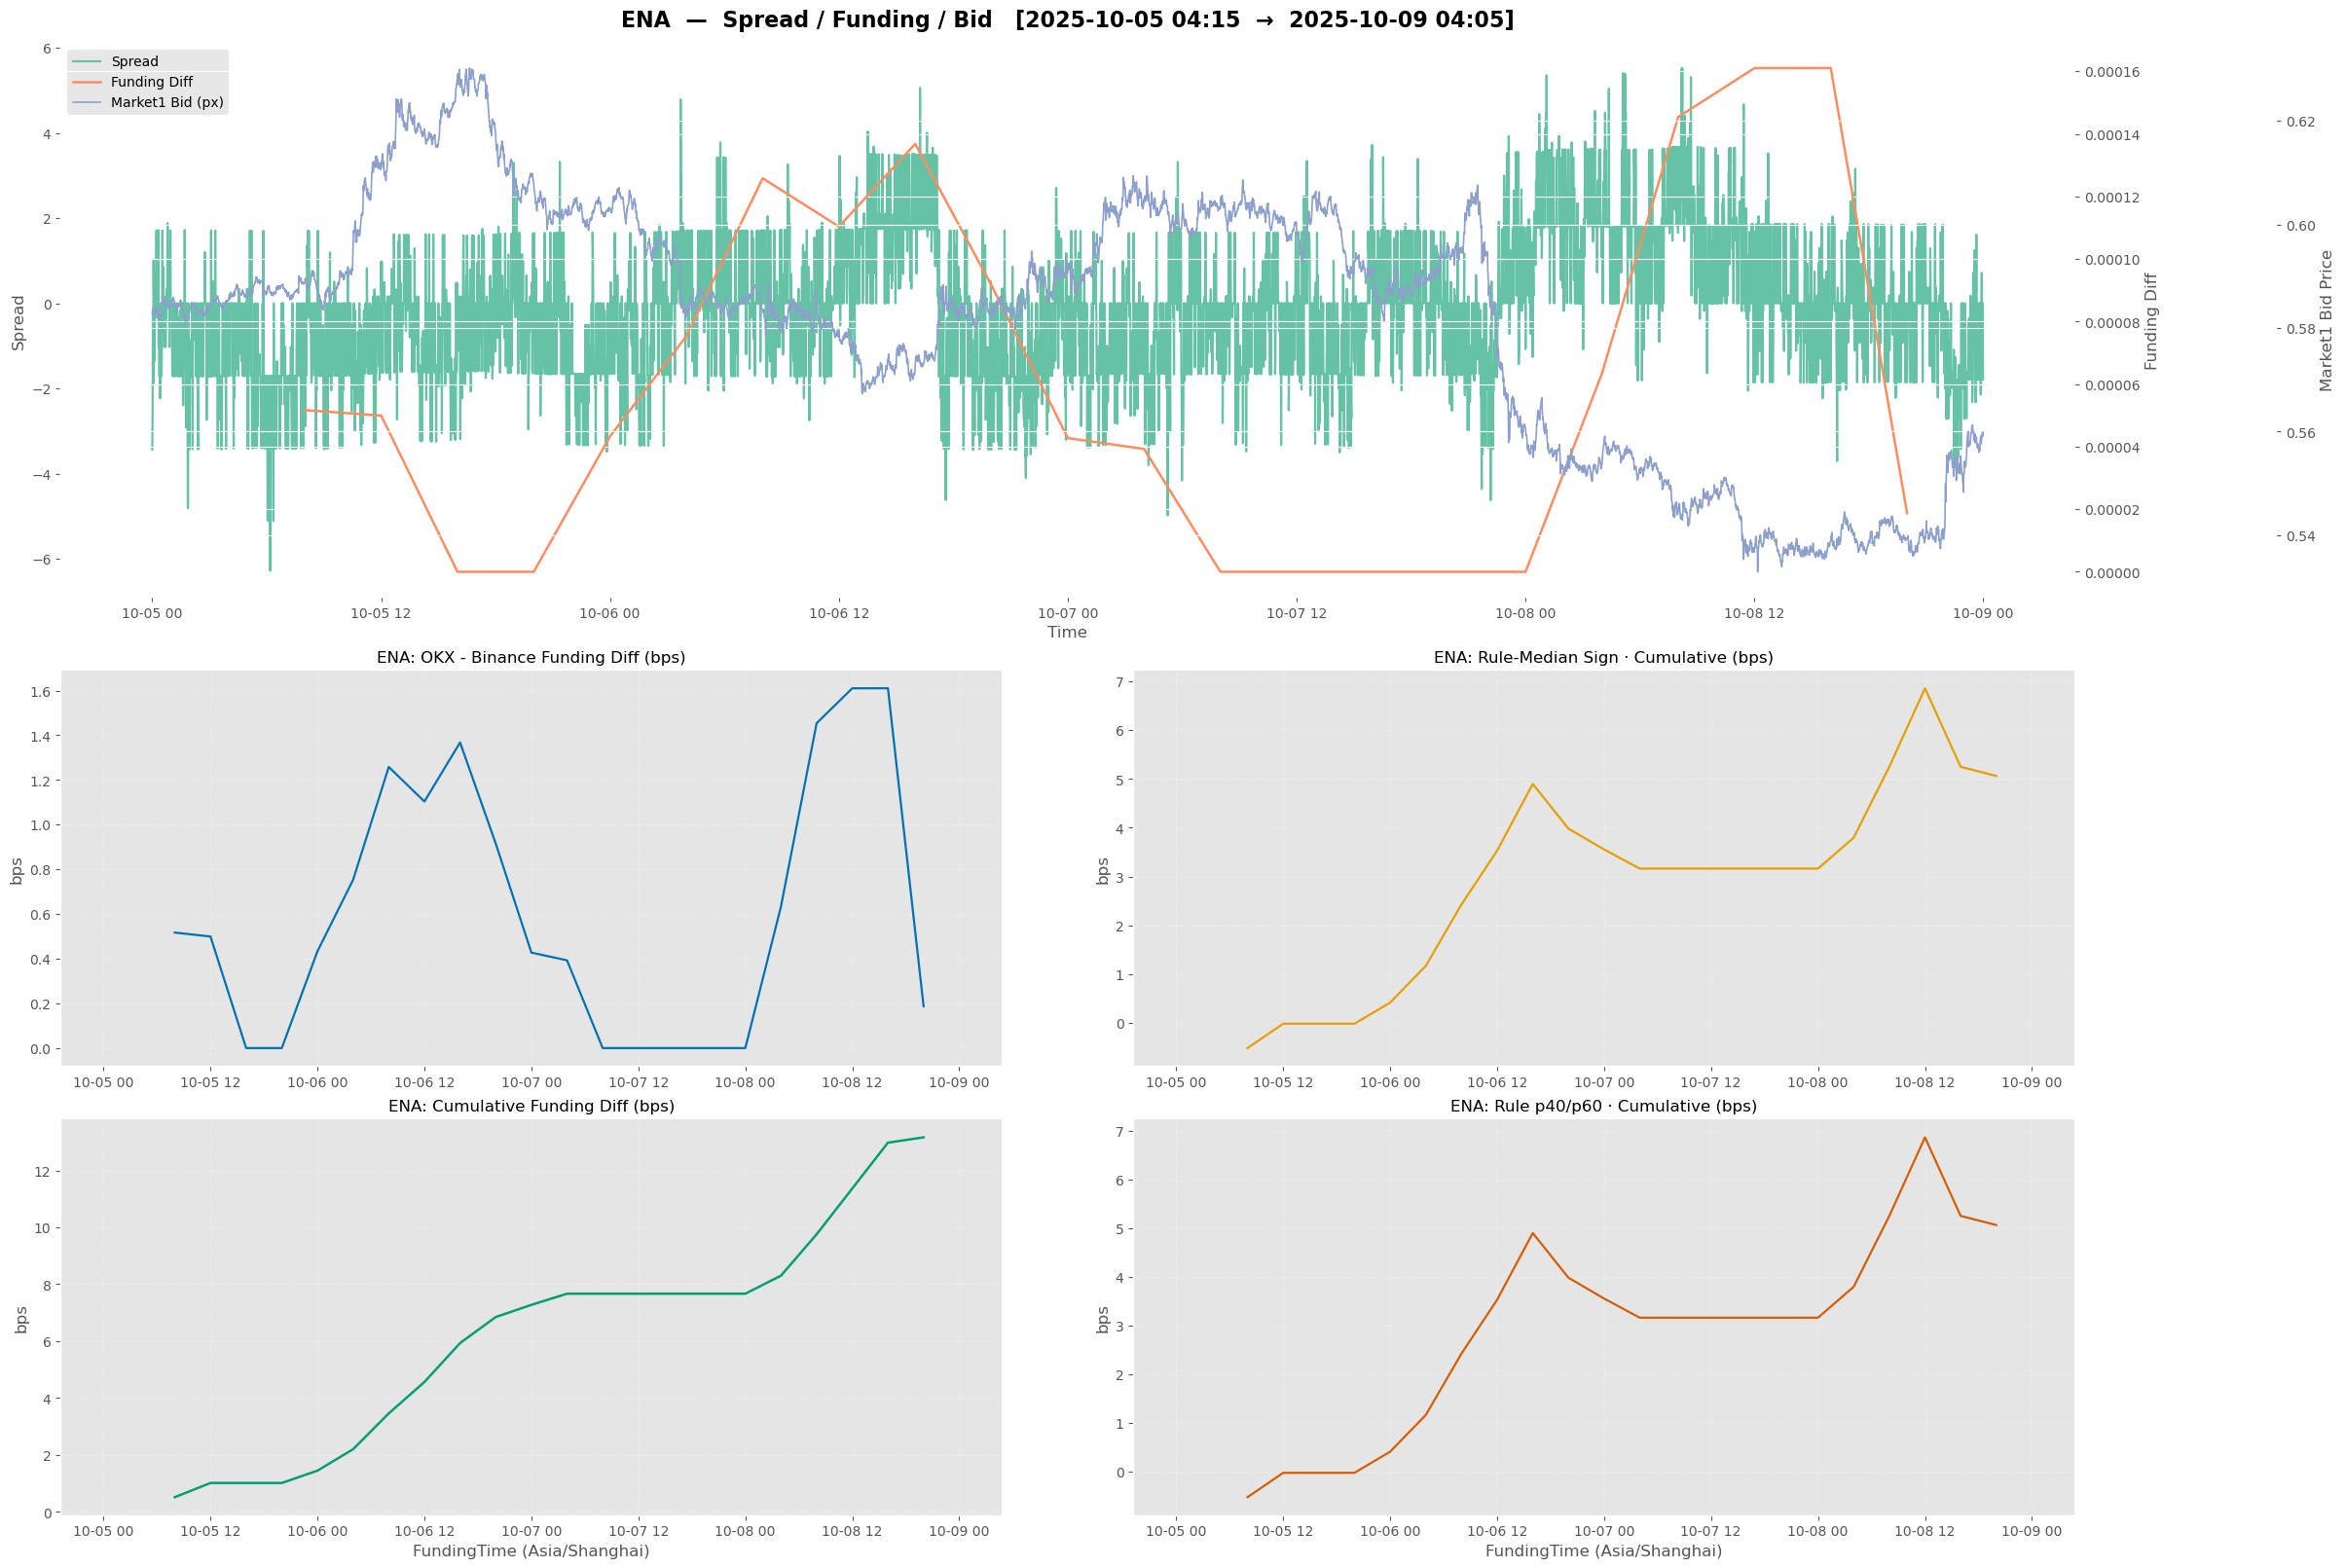

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

# # === 颜色配置 ===
# COLOR_SPREAD  = "#66C2A5"
# COLOR_FUNDING = "#FC8D62"
# COLOR_BID     = "#8DA0CB"
# C1 = "#0072B2"; C2 = "#009E73"; C3 = "#E69F00"; C4 = "#D55E00"

# # === 数据准备 ===
# symbol = ccy
# idx = spread_bid.index
# bid_px = cf_depth_resampled['market1_bid_price0'].reindex(idx)
# funding_sorted = funding_diff.sort_index()

# series_fd   = (funding_diff['funding_diff'] * 10000).dropna()
# cumsum_vals = funding_diff['funding_diff'].cumsum()
# if cumsum_vals.iloc[-1] < 0:
#     cumsum_vals = -cumsum_vals
# series_cum  = (cumsum_vals * 10000).dropna()
# series_adj  = (merged_df['funding_diff_adj_cumsum'] * 10000).dropna()
# series_sig  = (merged_df_type2['funding_diff_signed_cumsum'] * 10000).dropna()

# # === 画布布局 ===
# fig = plt.figure(constrained_layout=True, figsize=(24, 16))
# gs  = GridSpec(nrows=3, ncols=2, figure=fig, height_ratios=[1.4, 1, 1])

# # ------- 顶部大图 -------
# ax_top = fig.add_subplot(gs[0, :])
# ax_top.patch.set_visible(False)
# ax_top.grid(False)

# # 左轴：Spread
# l1, = ax_top.plot(idx, spread_bid.values, label='Spread',
#                   color=COLOR_SPREAD, linewidth=1.6, zorder=3)
# ax_top.set_ylabel('Spread')
# ax_top.set_xlabel('Time')

# # 右轴：Funding
# ax_top_r = ax_top.twinx()
# ax_top_r.patch.set_visible(False)
# l2, = ax_top_r.plot(funding_sorted.index, funding_sorted['funding_diff'].values,
#                     linestyle='-', linewidth=1.8, color=COLOR_FUNDING,
#                     label='Funding Diff', zorder=2)
# ax_top_r.set_ylabel('Funding Diff')

# # 第三个 y 轴：Bid
# ax_top_r2 = ax_top.twinx()
# ax_top_r2.spines['right'].set_position(('axes', 1.10))
# ax_top_r2.patch.set_visible(False)
# l3, = ax_top_r2.plot(idx, bid_px.values, label='Market1 Bid (px)',
#                      color=COLOR_BID, linewidth=1.2, zorder=1)
# ax_top_r2.set_ylabel('Market1 Bid Price')

# # ----✅ 标题：Symbol + 时间范围----
# title_str = (f"{symbol}  —  Spread / Funding / Bid"
#              f"   [{start_time.strftime('%Y-%m-%d %H:%M')}  →  {last_time.strftime('%Y-%m-%d %H:%M')}]")
# ax_top.set_title(title_str, fontsize=16, fontweight='bold', pad=12)

# # 图例
# lines = [l1, l2, l3]
# labels = [ln.get_label() for ln in lines]
# leg = ax_top.legend(lines, labels, loc='upper left')
# leg.get_frame().set_alpha(0.9)
# leg.get_frame().set_linewidth(0.0)

# # ------- 底部 2×2 -------
# ax11 = fig.add_subplot(gs[1, 0], sharex=ax_top)
# ax12 = fig.add_subplot(gs[1, 1], sharex=ax_top)
# ax21 = fig.add_subplot(gs[2, 0], sharex=ax_top)
# ax22 = fig.add_subplot(gs[2, 1], sharex=ax_top)

# for ax in (ax11, ax12, ax21, ax22):
#     ax.grid(True, linestyle='--', alpha=0.25)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

# # (1) Funding Diff
# ax11.plot(series_fd.index, series_fd.values, color=C1, linewidth=1.6)
# ax11.set_title(f'{symbol}: OKX - Binance Funding Diff (bps)', fontsize=12)
# ax11.set_ylabel('bps')

# # (2) Rule-Median Sign 累计
# ax12.plot(series_adj.index, series_adj.values, color=C3, linewidth=1.6)
# ax12.set_title(f'{symbol}: Rule-Median Sign · Cumulative (bps)', fontsize=12)
# ax12.set_ylabel('bps')

# # (3) Cumulative Funding Diff
# ax21.plot(series_cum.index, series_cum.values, color=C2, linewidth=1.8)
# ax21.set_title(f'{symbol}: Cumulative Funding Diff (bps)', fontsize=12)
# ax21.set_ylabel('bps')

# # (4) Rule p40/p60 累计
# ax22.plot(series_sig.index, series_sig.values, color=C4, linewidth=1.6)
# ax22.set_title(f'{symbol}: Rule p40/p60 · Cumulative (bps)', fontsize=12)
# ax22.set_ylabel('bps')

# ax21.set_xlabel('FundingTime (Asia/Shanghai)')
# ax22.set_xlabel('FundingTime (Asia/Shanghai)')

# plt.show()


In [8]:
import pandas as pd
# pd.read_csv('/Users/rayxu/Downloads/ASTER_USDT.close (1).csv')
# A：一把梭跳过坏行
df = pd.read_csv('/Users/rayxu/Downloads/ASTER_USDT.close (1).csv', on_bad_lines="skip")


In [11]:
import csv
import pandas as pd

def read_tsv_skip_bad(file_path: str):
    # 先拿到“期望列数”
    with open(file_path, "r", newline="") as f:
        r = csv.reader(f, delimiter="\t")
        header = next(r)
        expected = len(header)

    # 扫描出异常行号（pandas 的 skiprows 对数据行是 1-based；含表头时需 -1）
    bad = []
    with open(file_path, "r", newline="") as f:
        for i, row in enumerate(csv.reader(f, delimiter="\t"), start=1):
            if i == 1:
                continue
            if len(row) != expected:
                bad.append(i-1)  # 转为 skiprows 的索引（表头=0）

    # 精确跳过这些坏行
    return pd.read_csv(
        file_path,
        sep="\t",
        engine="python",
        dtype=str,
        skiprows=bad
    )

df = read_tsv_skip_bad('/Users/rayxu/Downloads/ASTER_USDT.close (1).csv')


In [12]:
df

,"start,sr_close,sr_close_real,swap1_order_id,swap1_avg_price,swap1_deal_amount,swap1_side,swap1_fee,swap1_fee_currency,swap1_is_maker,swap1_open_time,swap1_done_time,swap2_order_id,swap2_avg_price,swap2_deal_amount,swap2_side,swap2_fee,swap2_fee_currency,swap2_is_maker,swap2_open_time,swap2_done_time,swap2_depth_id,swap2_depth_bid0_price,swap2_depth_ask0_price,swap2_depth_bid1_price,swap2_depth_ask1_price,swap2_depth_timestamp,swap1_profit,swap2_profit,fee1,fee1_real,fee2,fee2_real,funding1,funding1_real,funding2,funding2_real,deposit1,deposit2,deposit1_real,deposit2_real,swap1_earn,swap1_earn_real,swap2_earn,swap2_earn_real,earn,earn_rate,real_earn,real_earn_rate,mode,pos_ids,maker_info,end"
0,2025-09-23 13:03:14.266255599 +0800 CST m=+463...
1,2025-09-23 13:03:21.923938501 +0800 CST m=+463...
2,2025-09-23 13:03:23.47350897 +0800 CST m=+4635...
3,2025-09-23 13:33:07.205563901 +0800 CST m=+481...
4,2025-09-23 13:33:09.312906976 +0800 CST m=+481...
...,...
3814,2025-10-11 09:54:43.326163766 +0800 CST m=+750...
3815,2025-10-11 13:29:13.378745343 +0800 CST m=+203...
3816,2025-10-11 13:29:13.369032696 +0800 CST m=+203...
3817,:13.728727897 +0800 CST m=+20377.006351392
